In [1]:
import pandas as pd
import numpy as np

import math
import os

# # Make TensorFlow logs less verbose
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import flwr as fl
import tensorflow_probability as tfp

import keras
from sklearn.model_selection import train_test_split
from utils import model as mod
from flwr.common import NDArrays, Scalar
from scipy.stats import pearsonr
from typing import Dict, Optional, Tuple, List, Union
import typing
import random
import json
np.random.seed(2048)
tf.random.set_seed(2048)
random.seed(2048)
tf.keras.utils.set_random_seed(2048)

NUM_EPOCHS=10
BATCH_SIZE=16
path='resultsbn'
strat='FedProx'

2023-09-27 15:46:08.135929: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 15:46:08.138610: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 15:46:08.188996: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 15:46:08.193857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 15:46:09.256125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
!pwd

/rds/user/sc2427/hpc-work/Final/FL


In [3]:
data=pd.read_csv("all_data.csv")

In [4]:
df = pd.DataFrame(columns = data.columns)


In [5]:

dfs_to_concat = []

for i in range(250, 1000):
    mean_data = data.loc[data['Stamp'] == i].mean()
    dfs_to_concat.append(mean_data)

result_df = pd.concat(dfs_to_concat, axis=1).T.reset_index(drop=True)

In [6]:
data_new=result_df

In [7]:
data_new.shape

(750, 38)

In [8]:
y_labels=df.columns[-8:]

In [9]:
x_labels=df.columns[1:-8]

In [10]:
x=np.array(data_new[x_labels])

In [11]:
y=np.array(data_new[y_labels])

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1)

In [13]:
x_train.shape

(562, 29)

In [14]:
# y_train=y_train.reshape((1,y_train.shape[0],y_train.shape[1]))
y_train.shape

(562, 8)

In [15]:

model_eval = mod()
model_eval.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError() ])

2023-09-27 15:46:15.428794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
def pcc(y_val, y_pred):
  temp={}
  for i in range(len(y_labels)):
    temp[y_labels[i]]=(pearsonr(y_val[:,i],y_pred[:,i])[0])
  return sum(list(temp.values()))/len(list(temp.values()))

In [17]:
class FlowerClient(fl.client.NumPyClient):

    def __init__(self, model,cid, x_train, y_train, x_val, y_val, path) -> None:
        self.model = model
        self.cid=cid
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val
        self.path=path

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=2)
        # loss, rmse = model.evaluate(self.x_val, self.y_val)
        loss,rmse=self.model.evaluate(self.x_val, self.y_val)

        # result["pr"].append(pr)


        try:
          data=pd.read_csv(f"{self.path}/result_{self.cid}.csv")
          data.drop(["Unnamed: 0"], axis=1, inplace=True)

        except:
          data=pd.DataFrame(columns=["round","Loss", "RMSE"])

        data=pd.concat([data,pd.Series([config['server_round'], loss, rmse ] , index=data.columns ).to_frame().T])
        data.to_csv(f"{self.path}/result_{self.cid}.csv")

        return loss, len(self.x_val), {"accuracy": rmse}


In [18]:

#import pearsonr
def get_eval_fn(model, result,result_train):
    """Return an evaluation function for server-side evaluation."""

    # Load data and model here to avoid the overhead of doing it in `evaluate` itself


    # The `evaluate` function will be called after every round
    def evaluate(server_round: int, weights: fl.common.NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        model.set_weights(weights)  # Update model with the latest parameters
        loss, rmse = model.evaluate(x_test, y_test)
        loss_train,rmse_train=model.evaluate(x_train, y_train)
        result_train['Losses'].append(loss_train)
        result_train['rmse'].append(rmse_train)

        result["Losses"].append(loss)
        result["rmse"].append(rmse)
        # result["pr"].append(pr)
        for i in range(len(y_labels)):
          result["pearson"][y_labels[i]].append(pearsonr(y_test[:,i],model.predict(x_test)[:,i])[0])
          result_train['pearson'][y_labels[i]].append(pearsonr(y_train[:,i],model.predict(x_train)[:,i])[0])


        return loss, {"accuracy": rmse}

    return evaluate

In [19]:
model_eval.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 1016 (3.97 KB)
Trainable params: 952 (3.72

In [20]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

def evaluate_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

In [21]:
ray_init_args = {
            "num_gpus": 0,
            "num_cpus": 1
        }
client_res={"num_gpus": 0, "num_cpus": 1}

In [22]:
inital=mod()
#for clients from 2 to 10, run the strategy for 10 rounds each and create a list of results
results=[]
results_train=[]
# for i in range(5):
for i in range(2,11):
    try:
        os.mkdir(f"{path}/{i}")
    except:
        print()
    try:
        os.mkdir(f"{path}/{i}/{strat}")
    except:
        print()
    
    NUM_CLIENTS = i
    # losses=[]
    def client_fn(cid: str) -> fl.client.Client:
        # Create model
        model = mod()
        model.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError()])    
        partition_size = math.floor(len(x_train) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_train_cid = x_train[idx_from:idx_to]
        full_y_train_cid = y_train[idx_from:idx_to]
    
    
        partition_size = math.floor(len(x_test) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_test_cid = x_test[idx_from:idx_to]
        full_y_test_cid = y_test[idx_from:idx_to]
    
        # Create and return client
        return FlowerClient(model,cid, full_x_train_cid, full_y_train_cid, full_x_test_cid, full_y_test_cid, f"{path}/{i}/{strat}")


    
    
    result={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    result_train={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    try:
        del strategy
    except:
        print('starting')
    # Create FedAvg strategy
    strategy = fl.server.strategy.FedProx(
      min_fit_clients=i,  # Never sample less than 10 clients for training
      evaluate_fn=get_eval_fn(model_eval, result,result_train),
      on_fit_config_fn=fit_config,
      on_evaluate_config_fn=evaluate_config,
      initial_parameters=fl.common.ndarrays_to_parameters(inital.get_weights()),
      proximal_mu=2
    )
    
    # Start simulation
    fl.simulation.start_simulation(
      client_fn=client_fn,
      num_clients=NUM_CLIENTS,
      config=fl.server.ServerConfig(num_rounds=10),
      strategy=strategy,
      ray_init_args=ray_init_args,
      client_resources=client_res,
    )
    results.append(result)
    results_train.append(result_train)
    # print(result)
    # try:
    #     data=pd.read_csv(f"{path}/combine_random{result['clients']}.csv")
    #     data.drop(["Unnamed: 0"], axis=1, inplace=True)
        
    # except:
    #     data=pd.DataFrame(columns=["Method", "Loss_Task1", "RMSE_Task1"])
    # data=pd.concat([data,pd.Series(["FedAvgEWC_Aug", result['Losses'][-1],result['rmse'][-1]] , index=data.columns ).to_frame().T])
    # data.to_csv(f"{path}/combine_random{result['clients']}.csv")



INFO flwr 2023-09-27 15:46:15,849 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)



starting


2023-09-27 15:46:19,565	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:46:19,757	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:46:21,078 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4400

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:46:23,247 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:46:23,248 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:46:23,249 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
(pid=232207) 2023-09-27 15:46:23.997854: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=232207) 2023-09-27 15:46:24.000803: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=232207) 2023-09-27 15:46:24.066085: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=232207) 2023-09-27 15:46:24.066596: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=232207) Epoch 1/10
18/18 [==============================] - 1s 4ms/step - loss: 8.6264 - root_mean_squared_error: 2.9371
(launch_and_fit pid=232207) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 3.8753 - root_mean_squared_error: 1.9686
(launch_and_fit pid=232207) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.4755 - root_mean_squared_error: 0.6896
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.3432 - root_mean_squared_error: 0.5858
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2518 - root_mean_squared_error: 0.5018
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2551 - root_mean_squared_error: 0.5051
(launch_and_fit pid=232207) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2335 - root_mean_squared_error: 0.4832
(launch_and_f

DEBUG flwr 2023-09-27 15:46:30,795 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 15:46:30,812 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


18/18 [==============================] - 0s 2ms/step - loss: 0.4968 - root_mean_squared_error: 0.7048
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.3108 - root_mean_squared_error: 0.5575
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2492 - root_mean_squared_error: 0.4992
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2269 - root_mean_squared_error: 0.4764
(launch_and_fit pid=232207) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2246 - root_mean_squared_error: 0.4740
(launch_and_fit pid=232207) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2239 - root_mean_squared_error: 0.4732
(launch_and_fit pid=232207) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2406 - root_mean_squared_error: 0.4905
(launch_and_fit pid=232207) Epoch 10/10
18/18 [=====

INFO flwr 2023-09-27 15:46:32,326 | server.py:119 | fit progress: (1, 0.2539086937904358, {'accuracy': 0.5038935542106628}, 9.077036575879902)
DEBUG flwr 2023-09-27 15:46:32,327 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2456 - root_mean_squared_error: 0.4956


DEBUG flwr 2023-09-27 15:46:33,051 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 15:46:33,053 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:46:33,054 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2622 - root_mean_squared_error: 0.5121
(launch_and_fit pid=232207) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2567 - root_mean_squared_error: 0.5067
(launch_and_fit pid=232207) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2485 - root_mean_squared_error: 0.4984
(launch_and_fit pid=232207) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2473 - root_mean_squared_error: 0.4973
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2273 - root_mean_squared_error: 0.4768
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2311 - root_mean_squared_error: 0.4807
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2354 - root_mean_squared_error: 0.4851
(launch_and_fit pid=232207) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:46:36,473 | server.py:232 | fit_round 2 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2172 - root_mean_squared_error: 0.4660
(launch_and_fit pid=232207) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2244 - root_mean_squared_error: 0.4738
(launch_and_fit pid=232207) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2265 - root_mean_squared_error: 0.4760
(launch_and_fit pid=232207) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2320 - root_mean_squared_error: 0.4816
(launch_and_fit pid=232207) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:46:37,979 | server.py:119 | fit progress: (2, 0.2339596301317215, {'accuracy': 0.4836937487125397}, 14.730655884835869)
DEBUG flwr 2023-09-27 15:46:37,981 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718


DEBUG flwr 2023-09-27 15:46:38,669 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:46:38,670 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2453 - root_mean_squared_error: 0.4953
(launch_and_fit pid=232207) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2582 - root_mean_squared_error: 0.5082
(launch_and_fit pid=232207) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2286 - root_mean_squared_error: 0.4781
(launch_and_fit pid=232207) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2239 - root_mean_squared_error: 0.4732
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2394 - root_mean_squared_error: 0.4893
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809
(launch_and_fit pid=232207) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:46:41,430 | server.py:232 | fit_round 3 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2211 - root_mean_squared_error: 0.4702
(launch_and_fit pid=232207) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4660
(launch_and_fit pid=232207) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2153 - root_mean_squared_error: 0.4640
(launch_and_fit pid=232207) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_fit pid=232207) Epoch 10/10
18/18 [==============================] - 0s 933us/step


INFO flwr 2023-09-27 15:46:42,965 | server.py:119 | fit progress: (3, 0.23120246827602386, {'accuracy': 0.4808351695537567}, 19.716424435842782)
DEBUG flwr 2023-09-27 15:46:42,966 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
(launch_and_evaluate pid=232207) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2af27ffdbaf0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 [==============================] - 0s 2ms/step - loss: 0.2275 - root_mean_squared_error: 0.4769


(launch_and_evaluate pid=232207) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2af43e8c8670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
DEBUG flwr 2023-09-27 15:46:43,517 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:46:43,518 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2350 - root_mean_squared_error: 0.4847
(launch_and_fit pid=232207) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2443 - root_mean_squared_error: 0.4943
(launch_and_fit pid=232207) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2378 - root_mean_squared_error: 0.4877
(launch_and_fit pid=232207) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2179 - root_mean_squared_error: 0.4668
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2161 - root_mean_squared_error: 0.4648
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2143 - root_mean_squared_error: 0.4629
(launch_and_fit pid=232207) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:46:46,587 | server.py:232 | fit_round 4 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704
(launch_and_fit pid=232207) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2179 - root_mean_squared_error: 0.4667
(launch_and_fit pid=232207) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2272 - root_mean_squared_error: 0.4767
(launch_and_fit pid=232207) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4690
(launch_and_fit pid=232207) Epoch 10/10
18/18 [==============================] - 0s 949us/step


INFO flwr 2023-09-27 15:46:47,914 | server.py:119 | fit progress: (4, 0.21768416464328766, {'accuracy': 0.4665663540363312}, 24.665814054198563)
DEBUG flwr 2023-09-27 15:46:47,915 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-09-27 15:46:48,429 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:46:48,430 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4691
(launch_and_fit pid=232207) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2265 - root_mean_squared_error: 0.4759
(launch_and_fit pid=232207) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2291 - root_mean_squared_error: 0.4786
(launch_and_fit pid=232207) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2274 - root_mean_squared_error: 0.4768
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2218 - root_mean_squared_error: 0.4709
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2242 - root_mean_squared_error: 0.4735
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2227 - root_mean_squared_error: 0.4720
(launch_and_fit pid=232207) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:46:51,375 | server.py:232 | fit_round 5 received 2 results and 0 failures


18/18 [==============================] - 0s 1ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755
(launch_and_fit pid=232207) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2147 - root_mean_squared_error: 0.4634
(launch_and_fit pid=232207) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2229 - root_mean_squared_error: 0.4721
(launch_and_fit pid=232207) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2088 - root_mean_squared_error: 0.4569
(launch_and_fit pid=232207) Epoch 10/10
18/18 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 15:46:53,017 | server.py:119 | fit progress: (5, 0.2307066023349762, {'accuracy': 0.4803192615509033}, 29.768362707924098)
DEBUG flwr 2023-09-27 15:46:53,018 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2344 - root_mean_squared_error: 0.4841


DEBUG flwr 2023-09-27 15:46:53,566 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:46:53,567 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2270 - root_mean_squared_error: 0.4765
(launch_and_fit pid=232207) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2265 - root_mean_squared_error: 0.4760
(launch_and_fit pid=232207) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4679
(launch_and_fit pid=232207) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2199 - root_mean_squared_error: 0.4689
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4598
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=232207) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:46:56,913 | server.py:232 | fit_round 6 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2328 - root_mean_squared_error: 0.4825
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2289 - root_mean_squared_error: 0.4784
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2141 - root_mean_squared_error: 0.4627
(launch_and_fit pid=232207) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2316 - root_mean_squared_error: 0.4812
(launch_and_fit pid=232207) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2229 - root_mean_squared_error: 0.4722
(launch_and_fit pid=232207) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2321 - root_mean_squared_error: 0.4818
(launch_and_fit pid=232207) Epoch 10/10
18/18 [=====

INFO flwr 2023-09-27 15:46:58,433 | server.py:119 | fit progress: (6, 0.21833494305610657, {'accuracy': 0.46726325154304504}, 35.18407927406952)
DEBUG flwr 2023-09-27 15:46:58,434 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2199 - root_mean_squared_error: 0.4689


DEBUG flwr 2023-09-27 15:46:58,960 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:46:58,962 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656
(launch_and_fit pid=232207) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2366 - root_mean_squared_error: 0.4864
(launch_and_fit pid=232207) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2308 - root_mean_squared_error: 0.4804
(launch_and_fit pid=232207) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2175 - root_mean_squared_error: 0.4663
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2135 - root_mean_squared_error: 0.4621
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2397 - root_mean_squared_error: 0.4896
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2297 - root_mean_squared_error: 0.4792
(launch_and_fit pid=232207) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:47:01,893 | server.py:232 | fit_round 7 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2150 - root_mean_squared_error: 0.4636
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2167 - root_mean_squared_error: 0.4656
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2183 - root_mean_squared_error: 0.4672
(launch_and_fit pid=232207) Epoch 7/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2033 - root_mean_squared_error: 0.4509
(launch_and_fit pid=232207) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2190 - root_mean_squared_error: 0.4680
(launch_and_fit pid=232207) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2064 - root_mean_squared_error: 0.4544
(launch_and_fit pid=232207) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:47:03,444 | server.py:119 | fit progress: (7, 0.21617624163627625, {'accuracy': 0.46494758129119873}, 40.19568701181561)
DEBUG flwr 2023-09-27 15:47:03,445 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2157 - root_mean_squared_error: 0.4645


DEBUG flwr 2023-09-27 15:47:03,977 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:47:03,979 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654
(launch_and_fit pid=232207) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2132 - root_mean_squared_error: 0.4617
(launch_and_fit pid=232207) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2070 - root_mean_squared_error: 0.4550
(launch_and_fit pid=232207) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4678
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2209 - root_mean_squared_error: 0.4700
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2272 - root_mean_squared_error: 0.4766
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2201 - root_mean_squared_error: 0.4692
(launch_and_fit pid=232207) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:47:07,205 | server.py:232 | fit_round 8 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2136 - root_mean_squared_error: 0.4622
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2273 - root_mean_squared_error: 0.4767
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2288 - root_mean_squared_error: 0.4784
(launch_and_fit pid=232207) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2199 - root_mean_squared_error: 0.4689
(launch_and_fit pid=232207) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2184 - root_mean_squared_error: 0.4674
(launch_and_fit pid=232207) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2297 - root_mean_squared_error: 0.4793
(launch_and_fit pid=232207) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:47:08,928 | server.py:119 | fit progress: (8, 0.2157357633113861, {'accuracy': 0.4644736051559448}, 45.67897717701271)
DEBUG flwr 2023-09-27 15:47:08,929 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-09-27 15:47:09,515 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:47:09,516 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=232207) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2506 - root_mean_squared_error: 0.5006
(launch_and_fit pid=232207) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2173 - root_mean_squared_error: 0.4662
(launch_and_fit pid=232207) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2191 - root_mean_squared_error: 0.4681
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2112 - root_mean_squared_error: 0.4596
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2204 - root_mean_squared_error: 0.4695
(launch_and_fit pid=232207) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:47:12,847 | server.py:232 | fit_round 9 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2456 - root_mean_squared_error: 0.4956
(launch_and_fit pid=232207) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2339 - root_mean_squared_error: 0.4837
(launch_and_fit pid=232207) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2230 - root_mean_squared_error: 0.4723
(launch_and_fit pid=232207) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2142 - root_mean_squared_error: 0.4628
(launch_and_fit pid=232207) Epoch 10/10
18/18 [==============================] - 0s 925us/step


INFO flwr 2023-09-27 15:47:14,155 | server.py:119 | fit progress: (9, 0.22895196080207825, {'accuracy': 0.4784892499446869}, 50.9065757188946)
DEBUG flwr 2023-09-27 15:47:14,156 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2246 - root_mean_squared_error: 0.4739


DEBUG flwr 2023-09-27 15:47:14,720 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:47:14,721 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2333 - root_mean_squared_error: 0.4830
(launch_and_fit pid=232207) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 0.2334 - root_mean_squared_error: 0.4831
(launch_and_fit pid=232207) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2148 - root_mean_squared_error: 0.4635
(launch_and_fit pid=232207) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2055 - root_mean_squared_error: 0.4534
(launch_and_fit pid=232207) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2181 - root_mean_squared_error: 0.4671
(launch_and_fit pid=232207) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2274 - root_mean_squared_error: 0.4769
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2151 - root_mean_squared_error: 0.4638
(launch_and_fit pid=232207) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:47:17,820 | server.py:232 | fit_round 10 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=232207) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=232207) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2183 - root_mean_squared_error: 0.4673
(launch_and_fit pid=232207) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2088 - root_mean_squared_error: 0.4569
(launch_and_fit pid=232207) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2080 - root_mean_squared_error: 0.4560
(launch_and_fit pid=232207) Epoch 10/10
18/18 [==============================] - 0s 961us/step


INFO flwr 2023-09-27 15:47:19,366 | server.py:119 | fit progress: (10, 0.2203608602285385, {'accuracy': 0.46942609548568726}, 56.11705793812871)
DEBUG flwr 2023-09-27 15:47:19,367 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-09-27 15:47:19,933 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-09-27 15:47:19,935 | server.py:147 | FL finished in 56.686357730068266
INFO flwr 2023-09-27 15:47:19,938 | app.py:218 | app_fit: losses_distributed [(1, 0.2539086788892746), (2, 0.2339596301317215), (3, 0.23120248317718506), (4, 0.21768415719270706), (5, 0.2307066023349762), (6, 0.21833495795726776), (7, 0.21617624163627625), (8, 0.2157357633113861), (9, 0.22895196080207825), (10, 0.2203608825802803)]
INFO flwr 2023-09-27 15:47:19,940 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:47:19,941 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:47:19,942 | app.py:221 | app_f

3/3 [==============================] - 0s 2ms/step - loss: 0.2173 - root_mean_squared_error: 0.4662

3/3 [==============================] - 0s 2ms/step - loss: 0.2234 - root_mean_squared_error: 0.4727


WARNING flwr 2023-09-27 15:47:19,983 | fedprox.py:141 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

WARNING flwr 2023-09-27 15:47:19,985 | fedavg.py:118 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-27 15:47:19,987 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-27 15:47:25,579	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jup

18/18 [==============================] - 0s 839us/step


INFO flwr 2023-09-27 15:47:28,688 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:47:28,689 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:47:28,690 | server.py:218 | fit_round 1: strategy sampled 3 clients (out of 3)
(pid=270710) 2023-09-27 15:47:29.527183: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=270710) 2023-09-27 15:47:29.529642: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=270710) 2023-09-27 15:47:29.590181: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=270710) 2023-09-27 15:47:29.590698: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=270710) Epoch 1/10
12/12 [==============================] - 1s 5ms/step - loss: 9.2992 - root_mean_squared_error: 3.0495
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 6.6265 - root_mean_squared_error: 2.5742
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 2.9318 - root_mean_squared_error: 1.7123
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.4937 - root_mean_squared_error: 0.7026
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.4052 - root_mean_squared_error: 0.6366
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2762 - root_mean_squared_error: 0.5255
(launch_and_fit pid=270710) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2551 - root_mean_squared_error: 0.5051
(launch_and_f

DEBUG flwr 2023-09-27 15:47:38,215 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 15:47:38,229 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


12/12 [==============================] - 0s 2ms/step - loss: 0.4687 - root_mean_squared_error: 0.6846
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.3947 - root_mean_squared_error: 0.6282
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2553 - root_mean_squared_error: 0.5052
(launch_and_fit pid=270710) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2523 - root_mean_squared_error: 0.5023
(launch_and_fit pid=270710) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2460 - root_mean_squared_error: 0.4959
(launch_and_fit pid=270710) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2315 - root_mean_squared_error: 0.4812
(launch_and_fit pid=270710) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:47:39,801 | server.py:119 | fit progress: (1, 0.2598985731601715, {'accuracy': 0.5098024606704712}, 11.11072574974969)
DEBUG flwr 2023-09-27 15:47:39,802 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2250 - root_mean_squared_error: 0.4743


DEBUG flwr 2023-09-27 15:47:40,861 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 15:47:40,862 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:47:40,863 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 4ms/step - loss: 0.3222 - root_mean_squared_error: 0.5676
(launch_and_fit pid=270710) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2799 - root_mean_squared_error: 0.5290
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2424 - root_mean_squared_error: 0.4924
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2424 - root_mean_squared_error: 0.4924
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2475 - root_mean_squared_error: 0.4975
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2303 - root_mean_squared_error: 0.4799
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2383 - root_mean_squared_error: 0.4882
(launch_and_fit pid=270710) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:47:45,632 | server.py:232 | fit_round 2 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.2591 - root_mean_squared_error: 0.5090
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2567 - root_mean_squared_error: 0.5067
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2456 - root_mean_squared_error: 0.4956
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2453 - root_mean_squared_error: 0.4953
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2352 - root_mean_squared_error: 0.4850
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2251 - root_mean_squared_error: 0.4744
(launch_and_fit pid=270710) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2131 - root_mean_squared_error: 0.4616
(launch_and_fit pid=270710) Epoch 8/10
12/12 [======

INFO flwr 2023-09-27 15:47:47,023 | server.py:119 | fit progress: (2, 0.23308873176574707, {'accuracy': 0.4827926456928253}, 18.332600648049265)
DEBUG flwr 2023-09-27 15:47:47,023 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2800 - root_mean_squared_error: 0.5291


(launch_and_evaluate pid=270710) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2abe1ff390d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2131 - root_mean_squared_error: 0.4617


DEBUG flwr 2023-09-27 15:47:48,018 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:47:48,020 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)
(launch_and_evaluate pid=270710) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2abe4ffdaca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 4ms/step - loss: 0.2068 - root_mean_squared_error: 0.4548
(launch_and_fit pid=270710) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2332 - root_mean_squared_error: 0.4830
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2225 - root_mean_squared_error: 0.4717
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2224 - root_mean_squared_error: 0.4716
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2278 - root_mean_squared_error: 0.4773
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2117 - root_mean_squared_error: 0.4601
(launch_and_fit pid=270710) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:47:52,494 | server.py:232 | fit_round 3 received 3 results and 0 failures


12/12 [==============================] - 1s 3ms/step - loss: 0.2378 - root_mean_squared_error: 0.4877
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2188 - root_mean_squared_error: 0.4677
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2148 - root_mean_squared_error: 0.4634
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2060 - root_mean_squared_error: 0.4538
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713
(launch_and_fit pid=270710) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2124 - root_mean_squared_error: 0.4609
(launch_and_fit pid=270710) Epoch 8/10
12/12 [======

INFO flwr 2023-09-27 15:47:53,923 | server.py:119 | fit progress: (3, 0.24058224260807037, {'accuracy': 0.4904918372631073}, 25.233114786911756)
DEBUG flwr 2023-09-27 15:47:53,924 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2955 - root_mean_squared_error: 0.5436


DEBUG flwr 2023-09-27 15:47:54,800 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:47:54,801 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2173 - root_mean_squared_error: 0.4661
(launch_and_fit pid=270710) Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.2155 - root_mean_squared_error: 0.4642
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4614
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1954 - root_mean_squared_error: 0.4421
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2070 - root_mean_squared_error: 0.4549
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2211 - root_mean_squared_error: 0.4703
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1999 - root_mean_squared_error: 0.4471
(launch_and_fit pid=270710) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:47:59,402 | server.py:232 | fit_round 4 received 3 results and 0 failures


12/12 [==============================] - 1s 3ms/step - loss: 0.2666 - root_mean_squared_error: 0.5164
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2340 - root_mean_squared_error: 0.4837
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2219 - root_mean_squared_error: 0.4711
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4748
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2258 - root_mean_squared_error: 0.4751
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706
(launch_and_fit pid=270710) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_fit pid=270710) Epoch 8/10
12/12 [======

INFO flwr 2023-09-27 15:48:00,983 | server.py:119 | fit progress: (4, 0.24986794590950012, {'accuracy': 0.49986791610717773}, 32.29284444777295)
DEBUG flwr 2023-09-27 15:48:00,984 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2280 - root_mean_squared_error: 0.4775


DEBUG flwr 2023-09-27 15:48:01,740 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:48:01,742 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2281 - root_mean_squared_error: 0.4776
(launch_and_fit pid=270710) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2438 - root_mean_squared_error: 0.4938
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2049 - root_mean_squared_error: 0.4526
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2173 - root_mean_squared_error: 0.4662
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2064 - root_mean_squared_error: 0.4543
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1995 - root_mean_squared_error: 0.4466
(launch_and_fit pid=270710) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:48:06,158 | server.py:232 | fit_round 5 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2294 - root_mean_squared_error: 0.4790
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2316 - root_mean_squared_error: 0.4812
(launch_and_fit pid=270710) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2303 - root_mean_squared_error: 0.4799
(launch_and_fit pid=270710) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760
(launch_and_fit pid=270710) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2219 - root_mean_squared_error: 0.4711
(launch_and_fit pid=270710) Epoch 10/10
18/18 [==============================] - 0s 964us/step


INFO flwr 2023-09-27 15:48:07,529 | server.py:119 | fit progress: (5, 0.22347979247570038, {'accuracy': 0.47273650765419006}, 38.83868568902835)
DEBUG flwr 2023-09-27 15:48:07,530 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501


DEBUG flwr 2023-09-27 15:48:08,417 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:48:08,419 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2001 - root_mean_squared_error: 0.4473
(launch_and_fit pid=270710) Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.2410 - root_mean_squared_error: 0.4909
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2268 - root_mean_squared_error: 0.4763
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2319 - root_mean_squared_error: 0.4815
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2096 - root_mean_squared_error: 0.4578
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2155 - root_mean_squared_error: 0.4643
(launch_and_fit pid=270710) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:48:13,212 | server.py:232 | fit_round 6 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4730
(launch_and_fit pid=270710) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2285 - root_mean_squared_error: 0.4780
(launch_and_fit pid=270710) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=270710) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2387 - root_mean_squared_error: 0.4886
(launch_and_fit pid=270710) Epoch 10/10
18/18 [==============================] - 0s 969us/step


INFO flwr 2023-09-27 15:48:14,930 | server.py:119 | fit progress: (6, 0.2284284085035324, {'accuracy': 0.4779418706893921}, 46.23994265310466)
DEBUG flwr 2023-09-27 15:48:14,931 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2092 - root_mean_squared_error: 0.4574


DEBUG flwr 2023-09-27 15:48:15,987 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:48:15,988 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 6ms/step - loss: 0.2666 - root_mean_squared_error: 0.5164
(launch_and_fit pid=270710) Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.2375 - root_mean_squared_error: 0.4874
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2013 - root_mean_squared_error: 0.4487
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1933 - root_mean_squared_error: 0.4397
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2061 - root_mean_squared_error: 0.4540
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454
(launch_and_fit pid=270710) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:48:20,309 | server.py:232 | fit_round 7 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.2325 - root_mean_squared_error: 0.4821
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2141 - root_mean_squared_error: 0.4628
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2066 - root_mean_squared_error: 0.4545
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2204 - root_mean_squared_error: 0.4695
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2124 - root_mean_squared_error: 0.4609
(launch_and_fit pid=270710) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1964 - root_mean_squared_error: 0.4431
(launch_and_fit pid=270710) Epoch 8/10
12/12 [======

INFO flwr 2023-09-27 15:48:22,002 | server.py:119 | fit progress: (7, 0.21762840449810028, {'accuracy': 0.46650660037994385}, 53.311795848887414)
DEBUG flwr 2023-09-27 15:48:22,003 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2572 - root_mean_squared_error: 0.5071


DEBUG flwr 2023-09-27 15:48:22,920 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:48:22,921 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469
(launch_and_fit pid=270710) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2563 - root_mean_squared_error: 0.5063
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2206 - root_mean_squared_error: 0.4697
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2298 - root_mean_squared_error: 0.4794
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2234 - root_mean_squared_error: 0.4726
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=270710) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:48:27,199 | server.py:232 | fit_round 8 received 3 results and 0 failures


12/12 [==============================] - 1s 3ms/step - loss: 0.2512 - root_mean_squared_error: 0.5012
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2325 - root_mean_squared_error: 0.4822
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2017 - root_mean_squared_error: 0.4492
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2091 - root_mean_squared_error: 0.4572
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564
(launch_and_fit pid=270710) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2005 - root_mean_squared_error: 0.4477
(launch_and_fit pid=270710) Epoch 8/10
12/12 [======

INFO flwr 2023-09-27 15:48:28,660 | server.py:119 | fit progress: (8, 0.22501197457313538, {'accuracy': 0.47435426712036133}, 59.969852360896766)
DEBUG flwr 2023-09-27 15:48:28,661 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2638 - root_mean_squared_error: 0.5136


DEBUG flwr 2023-09-27 15:48:29,553 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:48:29,554 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=270710) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2395 - root_mean_squared_error: 0.4893
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2214 - root_mean_squared_error: 0.4705
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2346 - root_mean_squared_error: 0.4844
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2126 - root_mean_squared_error: 0.4611
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2275 - root_mean_squared_error: 0.4769
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2243 - root_mean_squared_error: 0.4736
(launch_and_fit pid=270710) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:48:34,081 | server.py:232 | fit_round 9 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.1974 - root_mean_squared_error: 0.4443
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2136 - root_mean_squared_error: 0.4622
(launch_and_fit pid=270710) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1988 - root_mean_squared_error: 0.4458
(launch_and_fit pid=270710) Epoch 8/10
12/12 [==============================] - 0s 1ms/step - loss: 0.1981 - root_mean_squared_error: 0.4451
(launch_and_fit pid=270710) Epoch 9/10
12/12 [==============================] - 0s 1ms/step - loss: 0.2048 - root_mean_squared_error: 0.4526
(launch_and_fit pid=270710) Epoch 10/10
18/18 [==============================] - 0s 863us/step


INFO flwr 2023-09-27 15:48:35,439 | server.py:119 | fit progress: (9, 0.2216888815164566, {'accuracy': 0.4708385169506073}, 66.74858489399776)
DEBUG flwr 2023-09-27 15:48:35,439 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2010 - root_mean_squared_error: 0.4483


DEBUG flwr 2023-09-27 15:48:36,241 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:48:36,242 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 4ms/step - loss: 0.2643 - root_mean_squared_error: 0.5141
(launch_and_fit pid=270710) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2179 - root_mean_squared_error: 0.4668
(launch_and_fit pid=270710) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520
(launch_and_fit pid=270710) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734
(launch_and_fit pid=270710) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2367 - root_mean_squared_error: 0.4866
(launch_and_fit pid=270710) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2032 - root_mean_squared_error: 0.4508
(launch_and_fit pid=270710) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2028 - root_mean_squared_error: 0.4504
(launch_and_fit pid=270710) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:48:40,458 | server.py:232 | fit_round 10 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2150 - root_mean_squared_error: 0.4636
(launch_and_fit pid=270710) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1847 - root_mean_squared_error: 0.4298
(launch_and_fit pid=270710) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2090 - root_mean_squared_error: 0.4572
(launch_and_fit pid=270710) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=270710) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:48:41,797 | server.py:119 | fit progress: (10, 0.21318654716014862, {'accuracy': 0.4617213010787964}, 73.10652387002483)
DEBUG flwr 2023-09-27 15:48:41,798 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2525 - root_mean_squared_error: 0.5025


DEBUG flwr 2023-09-27 15:48:42,782 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-09-27 15:48:42,783 | server.py:147 | FL finished in 74.09282401483506
INFO flwr 2023-09-27 15:48:42,784 | app.py:218 | app_fit: losses_distributed [(1, 0.259928897023201), (2, 0.23330732186635336), (3, 0.24085677663485208), (4, 0.2503683865070343), (5, 0.223834494749705), (6, 0.22877765695254007), (7, 0.2180643081665039), (8, 0.22530576090017954), (9, 0.22219337026278177), (10, 0.213588019212087)]
INFO flwr 2023-09-27 15:48:42,785 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:48:42,785 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:48:42,786 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2598985731601715), (2, 0.23308873176574707), (3, 0.24058224260807037), (4, 0.24986794590950012), (5, 0.22347979247570038), (6, 0.2284284085035324), (7, 0.21762840449810028), (8, 0.22501197457313538), (9, 

2/2 [==============================] - 0s 3ms/step - loss: 0.1956 - root_mean_squared_error: 0.4423



2023-09-27 15:48:47,831	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:48:48,004	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8268 
INFO flwr 2023-09-27 15:48:49,690 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:48:51,150 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:48:51,151 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:48:51,152 | server.py:218 | fit_round 1: strategy sampled 4 clients (out of 4)
(pid=36536) 2023-09-27 15:48:52.170162: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=36536) 2023-09-27 15:48:52.173851: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=36536) 2023-09-27 15:48:52.256765: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=36536) 2023-09-27 15:48:52.257977: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=36536) Epoch 1/10
9/9 [==============================] - 1s 4ms/step - loss: 9.8095 - root_mean_squared_error: 3.1320
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 7.9503 - root_mean_squared_error: 2.8196
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 5.5939 - root_mean_squared_error: 2.3651
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 2.6494 - root_mean_squared_error: 1.6277
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.6067 - root_mean_squared_error: 0.7789
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3444 - root_mean_squared_error: 0.5869
(launch_and_fit pid=36536) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3461 - root_mean_squared_error: 0.5883
(launch_and_fit pid=36536) Epoch 8

DEBUG flwr 2023-09-27 15:49:04,220 | server.py:232 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-27 15:49:04,249 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


9/9 [==============================] - 1s 2ms/step - loss: 9.6557 - root_mean_squared_error: 3.1074
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 7.7599 - root_mean_squared_error: 2.7857
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 5.2822 - root_mean_squared_error: 2.2983
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 2.3596 - root_mean_squared_error: 1.5361
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.5185 - root_mean_squared_error: 0.7201
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3785 - root_mean_squared_error: 0.6152
(launch_and_fit pid=36536) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3650 - root_mean_squared_error: 0.6041
(launch_and_fit pid=36536) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:49:05,726 | server.py:119 | fit progress: (1, 0.2639978229999542, {'accuracy': 0.5138072371482849}, 14.574898386839777)
DEBUG flwr 2023-09-27 15:49:05,727 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 5ms/step - loss: 0.2812 - root_mean_squared_error: 0.5303


DEBUG flwr 2023-09-27 15:49:07,056 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-27 15:49:07,057 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:49:07,058 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2382 - root_mean_squared_error: 0.4881
(launch_and_fit pid=36536) Epoch 1/10
9/9 [==============================] - 1s 3ms/step - loss: 0.2858 - root_mean_squared_error: 0.5346
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2704 - root_mean_squared_error: 0.5200
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2527 - root_mean_squared_error: 0.5027
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2641 - root_mean_squared_error: 0.5139
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2646 - root_mean_squared_error: 0.5144
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2289 - root_mean_squared_error: 0.4784
(launch_and_fit pid=36536) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:49:12,326 | server.py:232 | fit_round 2 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2991 - root_mean_squared_error: 0.5469
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2518 - root_mean_squared_error: 0.5018
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2318 - root_mean_squared_error: 0.4814
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2267 - root_mean_squared_error: 0.4761
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2218 - root_mean_squared_error: 0.4709
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2108 - root_mean_squared_error: 0.4591
(launch_and_fit pid=36536) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2207 - root_mean_squared_error: 0.4698
(launch_and_fit pid=36536) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:49:13,787 | server.py:119 | fit progress: (2, 0.23481957614421844, {'accuracy': 0.484581857919693}, 22.635622022673488)
DEBUG flwr 2023-09-27 15:49:13,788 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)
(launch_and_evaluate pid=36536) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b583f9be160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 6ms/step - loss: 0.2107 - root_mean_squared_error: 0.4591


(launch_and_evaluate pid=36536) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2b573bf4e3a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2417 - root_mean_squared_error: 0.4917


DEBUG flwr 2023-09-27 15:49:14,983 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:49:14,984 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 4ms/step - loss: 0.2187 - root_mean_squared_error: 0.4676
(launch_and_fit pid=36536) Epoch 1/10
9/9 [==============================] - 1s 3ms/step - loss: 0.2877 - root_mean_squared_error: 0.5364
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2470 - root_mean_squared_error: 0.4970
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2311 - root_mean_squared_error: 0.4807
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2532 - root_mean_squared_error: 0.5032
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2328 - root_mean_squared_error: 0.4825
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2258 - root_mean_squared_error: 0.4752
(launch_and_fit pid=36536) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:49:20,622 | server.py:232 | fit_round 3 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2823 - root_mean_squared_error: 0.5313
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2220 - root_mean_squared_error: 0.4711
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2591 - root_mean_squared_error: 0.5090
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2327 - root_mean_squared_error: 0.4823
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4673
(launch_and_fit pid=36536) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2257 - root_mean_squared_error: 0.4751
(launch_and_fit pid=36536) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:49:22,067 | server.py:119 | fit progress: (3, 0.23473384976387024, {'accuracy': 0.4844933748245239}, 30.915856420993805)
DEBUG flwr 2023-09-27 15:49:22,068 | server.py:168 | evaluate_round 3: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2409 - root_mean_squared_error: 0.4908


DEBUG flwr 2023-09-27 15:49:23,242 | server.py:182 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:49:23,243 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2214 - root_mean_squared_error: 0.4705
(launch_and_fit pid=36536) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2282 - root_mean_squared_error: 0.4777
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2290 - root_mean_squared_error: 0.4786
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2135 - root_mean_squared_error: 0.4620
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2122 - root_mean_squared_error: 0.4606
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1806 - root_mean_squared_error: 0.4249
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1894 - root_mean_squared_error: 0.4352
(launch_and_fit pid=36536) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:49:28,704 | server.py:232 | fit_round 4 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2809 - root_mean_squared_error: 0.5300
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2460 - root_mean_squared_error: 0.4960
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2334 - root_mean_squared_error: 0.4831
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2311 - root_mean_squared_error: 0.4808
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4691
(launch_and_fit pid=36536) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2206 - root_mean_squared_error: 0.4697
(launch_and_fit pid=36536) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:49:30,166 | server.py:119 | fit progress: (4, 0.2299388349056244, {'accuracy': 0.4795193672180176}, 39.01465107081458)
DEBUG flwr 2023-09-27 15:49:30,167 | server.py:168 | evaluate_round 4: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2367 - root_mean_squared_error: 0.4865


DEBUG flwr 2023-09-27 15:49:31,302 | server.py:182 | evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:49:31,303 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2131 - root_mean_squared_error: 0.4616
(launch_and_fit pid=36536) Epoch 1/10
9/9 [==============================] - 1s 3ms/step - loss: 0.2663 - root_mean_squared_error: 0.5160
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2527 - root_mean_squared_error: 0.5027
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2477 - root_mean_squared_error: 0.4977
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2517 - root_mean_squared_error: 0.5017
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2359 - root_mean_squared_error: 0.4857
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2150 - root_mean_squared_error: 0.4637
(launch_and_fit pid=36536) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:49:37,142 | server.py:232 | fit_round 5 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4708
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2070 - root_mean_squared_error: 0.4550
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1774 - root_mean_squared_error: 0.4212
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2005 - root_mean_squared_error: 0.4478
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501
(launch_and_fit pid=36536) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2231 - root_mean_squared_error: 0.4723
(launch_and_fit pid=36536) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:49:38,638 | server.py:119 | fit progress: (5, 0.22622068226337433, {'accuracy': 0.4756266176700592}, 47.48685670364648)
DEBUG flwr 2023-09-27 15:49:38,639 | server.py:168 | evaluate_round 5: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 5ms/step - loss: 0.2397 - root_mean_squared_error: 0.4896


DEBUG flwr 2023-09-27 15:49:39,805 | server.py:182 | evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:49:39,806 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=36536) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2360 - root_mean_squared_error: 0.4858
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2510 - root_mean_squared_error: 0.5010
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2406 - root_mean_squared_error: 0.4905
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2119 - root_mean_squared_error: 0.4604
(launch_and_fit pid=36536) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:49:45,319 | server.py:232 | fit_round 6 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2427 - root_mean_squared_error: 0.4926
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2323 - root_mean_squared_error: 0.4819
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2242 - root_mean_squared_error: 0.4735
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2319 - root_mean_squared_error: 0.4815
(launch_and_fit pid=36536) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2350 - root_mean_squared_error: 0.4848
(launch_and_fit pid=36536) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:49:46,804 | server.py:119 | fit progress: (6, 0.22031162679195404, {'accuracy': 0.4693736433982849}, 55.65240545384586)
DEBUG flwr 2023-09-27 15:49:46,805 | server.py:168 | evaluate_round 6: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2362 - root_mean_squared_error: 0.4860


DEBUG flwr 2023-09-27 15:49:47,873 | server.py:182 | evaluate_round 6 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:49:47,874 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 4ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552
(launch_and_fit pid=36536) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2522 - root_mean_squared_error: 0.5022
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2159 - root_mean_squared_error: 0.4647
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2116 - root_mean_squared_error: 0.4600
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2089 - root_mean_squared_error: 0.4570
(launch_and_fit pid=36536) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:49:54,059 | server.py:232 | fit_round 7 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4678
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2389 - root_mean_squared_error: 0.4887
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2036 - root_mean_squared_error: 0.4512
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1915 - root_mean_squared_error: 0.4376
(launch_and_fit pid=36536) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1988 - root_mean_squared_error: 0.4459
(launch_and_fit pid=36536) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:49:55,658 | server.py:119 | fit progress: (7, 0.2274489551782608, {'accuracy': 0.47691610455513}, 64.50663786381483)
DEBUG flwr 2023-09-27 15:49:55,659 | server.py:168 | evaluate_round 7: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 5ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986


DEBUG flwr 2023-09-27 15:49:57,109 | server.py:182 | evaluate_round 7 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:49:57,110 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 4ms/step - loss: 0.2009 - root_mean_squared_error: 0.4482
(launch_and_fit pid=36536) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2146 - root_mean_squared_error: 0.4632
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2000 - root_mean_squared_error: 0.4472
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2003 - root_mean_squared_error: 0.4476
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1815 - root_mean_squared_error: 0.4261
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1908 - root_mean_squared_error: 0.4368
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1839 - root_mean_squared_error: 0.4288
(launch_and_fit pid=36536) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:50:02,643 | server.py:232 | fit_round 8 received 4 results and 0 failures


9/9 [==============================] - 1s 3ms/step - loss: 0.2703 - root_mean_squared_error: 0.5199
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2361 - root_mean_squared_error: 0.4859
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2340 - root_mean_squared_error: 0.4837
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2143 - root_mean_squared_error: 0.4629
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2227 - root_mean_squared_error: 0.4719
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699
(launch_and_fit pid=36536) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2068 - root_mean_squared_error: 0.4547
(launch_and_fit pid=36536) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:50:03,979 | server.py:119 | fit progress: (8, 0.21988555788993835, {'accuracy': 0.4689195454120636}, 72.82728632958606)
DEBUG flwr 2023-09-27 15:50:03,980 | server.py:168 | evaluate_round 8: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809


DEBUG flwr 2023-09-27 15:50:05,208 | server.py:182 | evaluate_round 8 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:50:05,209 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2020 - root_mean_squared_error: 0.4495
(launch_and_fit pid=36536) Epoch 1/10
9/9 [==============================] - 1s 3ms/step - loss: 0.2378 - root_mean_squared_error: 0.4876
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2230 - root_mean_squared_error: 0.4722
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2023 - root_mean_squared_error: 0.4498
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2014 - root_mean_squared_error: 0.4488
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2034 - root_mean_squared_error: 0.4510
(launch_and_fit pid=36536) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:50:11,050 | server.py:232 | fit_round 9 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2522 - root_mean_squared_error: 0.5022
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2647 - root_mean_squared_error: 0.5145
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2290 - root_mean_squared_error: 0.4785
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2201 - root_mean_squared_error: 0.4691
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2292 - root_mean_squared_error: 0.4788
(launch_and_fit pid=36536) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2000 - root_mean_squared_error: 0.4472
(launch_and_fit pid=36536) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:50:12,450 | server.py:119 | fit progress: (9, 0.22073175013065338, {'accuracy': 0.4698209762573242}, 81.29881146596745)
DEBUG flwr 2023-09-27 15:50:12,451 | server.py:168 | evaluate_round 9: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 4ms/step - loss: 0.2340 - root_mean_squared_error: 0.4838


DEBUG flwr 2023-09-27 15:50:13,657 | server.py:182 | evaluate_round 9 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:50:13,659 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 4ms/step - loss: 0.2449 - root_mean_squared_error: 0.4949
(launch_and_fit pid=36536) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2114 - root_mean_squared_error: 0.4598
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1949 - root_mean_squared_error: 0.4415
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1946 - root_mean_squared_error: 0.4411
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1988 - root_mean_squared_error: 0.4458
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2006 - root_mean_squared_error: 0.4479
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1853 - root_mean_squared_error: 0.4305
(launch_and_fit pid=36536) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 15:50:19,285 | server.py:232 | fit_round 10 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2402 - root_mean_squared_error: 0.4901
(launch_and_fit pid=36536) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2418 - root_mean_squared_error: 0.4917
(launch_and_fit pid=36536) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2192 - root_mean_squared_error: 0.4681
(launch_and_fit pid=36536) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=36536) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2007 - root_mean_squared_error: 0.4480
(launch_and_fit pid=36536) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=36536) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1995 - root_mean_squared_error: 0.4466
(launch_and_fit pid=36536) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 15:50:20,792 | server.py:119 | fit progress: (10, 0.22465825080871582, {'accuracy': 0.4739812910556793}, 89.6403399547562)
DEBUG flwr 2023-09-27 15:50:20,793 | server.py:168 | evaluate_round 10: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2117 - root_mean_squared_error: 0.4602


DEBUG flwr 2023-09-27 15:50:22,163 | server.py:182 | evaluate_round 10 received 4 results and 0 failures
INFO flwr 2023-09-27 15:50:22,164 | server.py:147 | FL finished in 91.0124700316228
INFO flwr 2023-09-27 15:50:22,164 | app.py:218 | app_fit: losses_distributed [(1, 0.2639978267252445), (2, 0.23481957614421844), (3, 0.23473383858799934), (4, 0.2299388386309147), (5, 0.22622067481279373), (6, 0.22031164169311523), (7, 0.2274489514529705), (8, 0.21988554298877716), (9, 0.22073175758123398), (10, 0.22465825825929642)]
INFO flwr 2023-09-27 15:50:22,165 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:50:22,166 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:50:22,166 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2639978229999542), (2, 0.23481957614421844), (3, 0.23473384976387024), (4, 0.2299388349056244), (5, 0.22622068226337433), (6, 0.22031162679195404), (7, 0.2274489551782608), (8, 0.21988555788993835), (


2/2 [==============================] - 0s 3ms/step - loss: 0.2037 - root_mean_squared_error: 0.4513


2023-09-27 15:50:28,449	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:50:28,545	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8268 
INFO flwr 2023-09-27 15:50:29,882 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 935us/step


INFO flwr 2023-09-27 15:50:31,445 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:50:31,445 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:50:31,446 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 5)
(pid=92572) 2023-09-27 15:50:32.551014: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=92572) 2023-09-27 15:50:32.553551: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=92572) 2023-09-27 15:50:32.615047: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=92572) 2023-09-27 15:50:32.616742: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=92572) Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 9.8020 - root_mean_squared_error: 3.1308
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 8.3356 - root_mean_squared_error: 2.8871
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 6.8007 - root_mean_squared_error: 2.6078
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 4.7236 - root_mean_squared_error: 2.1734
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 2.4038 - root_mean_squared_error: 1.5504
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.7727 - root_mean_squared_error: 0.8790
(launch_and_fit pid=92572) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.3705 - root_mean_squared_error: 0.6087
(launch_and_fit pid=92572) Epoch 8

DEBUG flwr 2023-09-27 15:50:46,276 | server.py:232 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 15:50:46,300 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


7/7 [==============================] - 1s 4ms/step - loss: 9.9387 - root_mean_squared_error: 3.1526
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 8.4377 - root_mean_squared_error: 2.9048
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 6.9131 - root_mean_squared_error: 2.6293
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 4.8213 - root_mean_squared_error: 2.1957
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 2.5055 - root_mean_squared_error: 1.5829
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.8178 - root_mean_squared_error: 0.9043
(launch_and_fit pid=92572) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2969 - root_mean_squared_error: 0.5449
(launch_and_fit pid=92572) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-27 15:50:47,736 | server.py:119 | fit progress: (1, 0.2835961878299713, {'accuracy': 0.5325375199317932}, 16.29023737180978)
DEBUG flwr 2023-09-27 15:50:47,737 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.3302 - root_mean_squared_error: 0.5746


DEBUG flwr 2023-09-27 15:50:49,216 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 15:50:49,217 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:50:49,218 | server.py:218 | fit_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=92572) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b5d152d9160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/

2/2 [==============================] - 0s 3ms/step - loss: 0.2524 - root_mean_squared_error: 0.5024
(launch_and_fit pid=92572) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2801 - root_mean_squared_error: 0.5293
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2561 - root_mean_squared_error: 0.5060
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2256 - root_mean_squared_error: 0.4750
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1888 - root_mean_squared_error: 0.4345
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2009 - root_mean_squared_error: 0.4483
(launch_and_fit pid=92572) Epoch 7/10
7/7 [=============================

DEBUG flwr 2023-09-27 15:50:55,454 | server.py:232 | fit_round 2 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.3261 - root_mean_squared_error: 0.5710
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2531 - root_mean_squared_error: 0.5031
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2385 - root_mean_squared_error: 0.4884
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2644 - root_mean_squared_error: 0.5142
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2222 - root_mean_squared_error: 0.4713
(launch_and_fit pid=92572) Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2396 - root_mean_squared_error: 0.4895
(launch_and_fit pid=92572) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-27 15:50:56,986 | server.py:119 | fit progress: (2, 0.23896709084510803, {'accuracy': 0.48884260654449463}, 25.539720370899886)
DEBUG flwr 2023-09-27 15:50:56,987 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=92572) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2b5ebb4a0c10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2832 - root_mean_squared_error: 0.5321


DEBUG flwr 2023-09-27 15:50:58,512 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:50:58,513 | server.py:218 | fit_round 3: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 7ms/step - loss: 0.2320 - root_mean_squared_error: 0.4816
(launch_and_fit pid=92572) Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 0.2463 - root_mean_squared_error: 0.4963
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2099 - root_mean_squared_error: 0.4582
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2125 - root_mean_squared_error: 0.4610
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2190 - root_mean_squared_error: 0.4680
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2144 - root_mean_squared_error: 0.4631
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1958 - root_mean_squared_error: 0.4425
(launch_and_fit pid=92572) Epoch 7/10
7/7 [=============================

DEBUG flwr 2023-09-27 15:51:05,133 | server.py:232 | fit_round 3 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2866 - root_mean_squared_error: 0.5353
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2736 - root_mean_squared_error: 0.5230
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2567 - root_mean_squared_error: 0.5067
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2271 - root_mean_squared_error: 0.4765
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2268 - root_mean_squared_error: 0.4763
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2356 - root_mean_squared_error: 0.4853
(launch_and_fit pid=92572) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=92572) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-27 15:51:07,182 | server.py:119 | fit progress: (3, 0.24441580474376678, {'accuracy': 0.4943842589855194}, 35.736433510668576)
DEBUG flwr 2023-09-27 15:51:07,184 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2316 - root_mean_squared_error: 0.4813


DEBUG flwr 2023-09-27 15:51:08,715 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:51:08,716 | server.py:218 | fit_round 4: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 6ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588
(launch_and_fit pid=92572) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2374 - root_mean_squared_error: 0.4872
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2151 - root_mean_squared_error: 0.4637
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1898 - root_mean_squared_error: 0.4356
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1870 - root_mean_squared_error: 0.4324
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1875 - root_mean_squared_error: 0.4330
(launch_and_fit pid=92572) Epoch 7/10
7/7 [=============================

DEBUG flwr 2023-09-27 15:51:15,317 | server.py:232 | fit_round 4 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2694 - root_mean_squared_error: 0.5191
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2407 - root_mean_squared_error: 0.4907
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2462 - root_mean_squared_error: 0.4962
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2132 - root_mean_squared_error: 0.4618
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2123 - root_mean_squared_error: 0.4608
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656
(launch_and_fit pid=92572) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2343 - root_mean_squared_error: 0.4841
(launch_and_fit pid=92572) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-27 15:51:16,873 | server.py:119 | fit progress: (4, 0.22946986556053162, {'accuracy': 0.47903013229370117}, 45.42704993393272)
DEBUG flwr 2023-09-27 15:51:16,874 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800


DEBUG flwr 2023-09-27 15:51:18,360 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:51:18,361 | server.py:218 | fit_round 5: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2571 - root_mean_squared_error: 0.5071
(launch_and_fit pid=92572) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4731
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2123 - root_mean_squared_error: 0.4607
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1999 - root_mean_squared_error: 0.4471
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1907 - root_mean_squared_error: 0.4367
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1805 - root_mean_squared_error: 0.4249
(launch_and_fit pid=92572) Epoch 7/10
7/7 [=============================

DEBUG flwr 2023-09-27 15:51:24,215 | server.py:232 | fit_round 5 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2502 - root_mean_squared_error: 0.5002
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2290 - root_mean_squared_error: 0.4785
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2091 - root_mean_squared_error: 0.4572
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1967 - root_mean_squared_error: 0.4436
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1985 - root_mean_squared_error: 0.4455
(launch_and_fit pid=92572) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1868 - root_mean_squared_error: 0.4322
(launch_and_fit pid=92572) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-27 15:51:25,651 | server.py:119 | fit progress: (5, 0.23601555824279785, {'accuracy': 0.48581433296203613}, 54.204620549920946)
DEBUG flwr 2023-09-27 15:51:25,652 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2764 - root_mean_squared_error: 0.5257


DEBUG flwr 2023-09-27 15:51:27,129 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:51:27,131 | server.py:218 | fit_round 6: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2050 - root_mean_squared_error: 0.4527
(launch_and_fit pid=92572) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2630 - root_mean_squared_error: 0.5129
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2396 - root_mean_squared_error: 0.4895
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2293 - root_mean_squared_error: 0.4788
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2113 - root_mean_squared_error: 0.4597
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2162 - root_mean_squared_error: 0.4649
(launch_and_fit pid=92572) Epoch 7/10
7/7 [=============================

DEBUG flwr 2023-09-27 15:51:33,202 | server.py:232 | fit_round 6 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2686 - root_mean_squared_error: 0.5183
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2151 - root_mean_squared_error: 0.4638
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2077 - root_mean_squared_error: 0.4557
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1980 - root_mean_squared_error: 0.4449
(launch_and_fit pid=92572) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2069 - root_mean_squared_error: 0.4548
(launch_and_fit pid=92572) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-27 15:51:34,661 | server.py:119 | fit progress: (6, 0.22283488512039185, {'accuracy': 0.4720539152622223}, 63.21480036294088)
DEBUG flwr 2023-09-27 15:51:34,662 | server.py:168 | evaluate_round 6: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2569 - root_mean_squared_error: 0.5069


DEBUG flwr 2023-09-27 15:51:36,193 | server.py:182 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:51:36,195 | server.py:218 | fit_round 7: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987
(launch_and_fit pid=92572) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2076 - root_mean_squared_error: 0.4556
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1900 - root_mean_squared_error: 0.4358
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1969 - root_mean_squared_error: 0.4437
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1893 - root_mean_squared_error: 0.4351
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1867 - root_mean_squared_error: 0.4321
(launch_and_fit pid=92572) Epoch 7/10
7/7 [=============================

DEBUG flwr 2023-09-27 15:51:42,127 | server.py:232 | fit_round 7 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2369 - root_mean_squared_error: 0.4867
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2399 - root_mean_squared_error: 0.4898
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2269 - root_mean_squared_error: 0.4763
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2046 - root_mean_squared_error: 0.4523
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1918 - root_mean_squared_error: 0.4379
(launch_and_fit pid=92572) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469
(launch_and_fit pid=92572) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-27 15:51:43,578 | server.py:119 | fit progress: (7, 0.2201467901468277, {'accuracy': 0.4691980183124542}, 72.13253786088899)
DEBUG flwr 2023-09-27 15:51:43,579 | server.py:168 | evaluate_round 7: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2144 - root_mean_squared_error: 0.4631


DEBUG flwr 2023-09-27 15:51:45,431 | server.py:182 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:51:45,433 | server.py:218 | fit_round 8: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1975 - root_mean_squared_error: 0.4444
(launch_and_fit pid=92572) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2367 - root_mean_squared_error: 0.4865
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1934 - root_mean_squared_error: 0.4397
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1998 - root_mean_squared_error: 0.4470
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2034 - root_mean_squared_error: 0.4510
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1946 - root_mean_squared_error: 0.4412
(launch_and_fit pid=92572) Epoch 7/10
7/7 [=============================

DEBUG flwr 2023-09-27 15:51:51,293 | server.py:232 | fit_round 8 received 5 results and 0 failures


7/7 [==============================] - 1s 3ms/step - loss: 0.2657 - root_mean_squared_error: 0.5155
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2469 - root_mean_squared_error: 0.4969
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2300 - root_mean_squared_error: 0.4796
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2340 - root_mean_squared_error: 0.4837
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2092 - root_mean_squared_error: 0.4574
(launch_and_fit pid=92572) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2330 - root_mean_squared_error: 0.4827
(launch_and_fit pid=92572) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-27 15:51:52,813 | server.py:119 | fit progress: (8, 0.22233597934246063, {'accuracy': 0.4715251624584198}, 81.36735585099086)
DEBUG flwr 2023-09-27 15:51:52,814 | server.py:168 | evaluate_round 8: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1989 - root_mean_squared_error: 0.4460


DEBUG flwr 2023-09-27 15:51:54,151 | server.py:182 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:51:54,153 | server.py:218 | fit_round 9: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2549 - root_mean_squared_error: 0.5049
(launch_and_fit pid=92572) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2568 - root_mean_squared_error: 0.5068
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2389 - root_mean_squared_error: 0.4887
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2468 - root_mean_squared_error: 0.4968
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2229 - root_mean_squared_error: 0.4721
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1983 - root_mean_squared_error: 0.4453
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2113 - root_mean_squared_error: 0.4597
(launch_and_fit pid=92572) Epoch 7/10
7/7 [=============================

DEBUG flwr 2023-09-27 15:52:00,554 | server.py:232 | fit_round 9 received 5 results and 0 failures


7/7 [==============================] - 1s 3ms/step - loss: 0.2461 - root_mean_squared_error: 0.4961
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2182 - root_mean_squared_error: 0.4672
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1977 - root_mean_squared_error: 0.4447
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2003 - root_mean_squared_error: 0.4475
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2188 - root_mean_squared_error: 0.4677
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1998 - root_mean_squared_error: 0.4470
(launch_and_fit pid=92572) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1858 - root_mean_squared_error: 0.4310
(launch_and_fit pid=92572) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-27 15:52:02,139 | server.py:119 | fit progress: (9, 0.2229449301958084, {'accuracy': 0.4721704423427582}, 90.69296298967674)
DEBUG flwr 2023-09-27 15:52:02,140 | server.py:168 | evaluate_round 9: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1864 - root_mean_squared_error: 0.4318


DEBUG flwr 2023-09-27 15:52:03,642 | server.py:182 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:52:03,644 | server.py:218 | fit_round 10: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 5ms/step - loss: 0.1942 - root_mean_squared_error: 0.4407
(launch_and_fit pid=92572) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2623 - root_mean_squared_error: 0.5121
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2386 - root_mean_squared_error: 0.4884
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2033 - root_mean_squared_error: 0.4509
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2338 - root_mean_squared_error: 0.4835
(launch_and_fit pid=92572) Epoch 7/10
7/7 [=============================

DEBUG flwr 2023-09-27 15:52:09,438 | server.py:232 | fit_round 10 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2919 - root_mean_squared_error: 0.5403
(launch_and_fit pid=92572) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2024 - root_mean_squared_error: 0.4499
(launch_and_fit pid=92572) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
(launch_and_fit pid=92572) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2076 - root_mean_squared_error: 0.4556
(launch_and_fit pid=92572) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2040 - root_mean_squared_error: 0.4516
(launch_and_fit pid=92572) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1887 - root_mean_squared_error: 0.4344
(launch_and_fit pid=92572) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2060 - root_mean_squared_error: 0.4539
(launch_and_fit pid=92572) Epoch 8/10
7/7 [=============================

INFO flwr 2023-09-27 15:52:11,017 | server.py:119 | fit progress: (10, 0.21884001791477203, {'accuracy': 0.46780338883399963}, 99.57061395375058)
DEBUG flwr 2023-09-27 15:52:11,017 | server.py:168 | evaluate_round 10: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1763 - root_mean_squared_error: 0.4198


DEBUG flwr 2023-09-27 15:52:12,998 | server.py:182 | evaluate_round 10 received 5 results and 0 failures
INFO flwr 2023-09-27 15:52:12,999 | server.py:147 | FL finished in 101.55313461087644
INFO flwr 2023-09-27 15:52:13,000 | app.py:218 | app_fit: losses_distributed [(1, 0.2838042229413986), (2, 0.2393106609582901), (3, 0.24462321400642395), (4, 0.2296955943107605), (5, 0.23629532158374786), (6, 0.22288302183151246), (7, 0.2204374998807907), (8, 0.22269606292247773), (9, 0.2231126308441162), (10, 0.21893965303897858)]
INFO flwr 2023-09-27 15:52:13,001 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:52:13,002 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:52:13,003 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2835961878299713), (2, 0.23896709084510803), (3, 0.24441580474376678), (4, 0.22946986556053162), (5, 0.23601555824279785), (6, 0.22283488512039185), (7, 0.2201467901468277), (8, 0.22233597934246063), 

2/2 [==============================] - 0s 3ms/step - loss: 0.1966 - root_mean_squared_error: 0.4433



2023-09-27 15:52:20,189	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:52:20,317	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:52:21,669 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'memory': 94679

18/18 [==============================] - 0s 959us/step


INFO flwr 2023-09-27 15:52:23,204 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:52:23,206 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:52:23,207 | server.py:218 | fit_round 1: strategy sampled 6 clients (out of 6)
(pid=144610) 2023-09-27 15:52:24.299296: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=144610) 2023-09-27 15:52:24.310574: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=144610) 2023-09-27 15:52:24.361331: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=144610) 2023-09-27 15:52:24.361825: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=144610) Epoch 1/10
6/6 [==============================] - 1s 6ms/step - loss: 10.3425 - root_mean_squared_error: 3.2160
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 8.9390 - root_mean_squared_error: 2.9898
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 7.7337 - root_mean_squared_error: 2.7810
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 6.0611 - root_mean_squared_error: 2.4619
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 4.0531 - root_mean_squared_error: 2.0132
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 2.0431 - root_mean_squared_error: 1.4294
(launch_and_fit pid=144610) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6660 - root_mean_squared_error: 0.8161
(launch_and_fit pid=144610

DEBUG flwr 2023-09-27 15:52:39,699 | server.py:232 | fit_round 1 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 9.9358 - root_mean_squared_error: 3.1521
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 8.5886 - root_mean_squared_error: 2.9306
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 7.3880 - root_mean_squared_error: 2.7181
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 5.8111 - root_mean_squared_error: 2.4106
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 3.8714 - root_mean_squared_error: 1.9676
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 1.9569 - root_mean_squared_error: 1.3989
(launch_and_fit pid=144610) Epoch 7/10


WARNING flwr 2023-09-27 15:52:39,741 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


6/6 [==============================] - 0s 2ms/step - loss: 0.7208 - root_mean_squared_error: 0.8490
(launch_and_fit pid=144610) Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.3300 - root_mean_squared_error: 0.5745
(launch_and_fit pid=144610) Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 0.4027 - root_mean_squared_error: 0.6346
(launch_and_fit pid=144610) Epoch 10/10
18/18 [==============================] - 0s 832us/step


INFO flwr 2023-09-27 15:52:40,992 | server.py:119 | fit progress: (1, 0.264272004365921, {'accuracy': 0.51407390832901}, 17.786128216888756)
DEBUG flwr 2023-09-27 15:52:40,993 | server.py:168 | evaluate_round 1: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 123ms/step - loss: 0.3328 - root_mean_squared_error: 0.5769


(launch_and_evaluate pid=144610) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2aebb3d491f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
DEBUG flwr 2023-09-27 15:52:42,640 | server.py:182 | evaluate_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-27 15:52:42,641 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:52:42,643 | server.py:218 | fit_round 2: strate

1/1 [==============================] - 0s 113ms/step - loss: 0.2664 - root_mean_squared_error: 0.5162


1/1 [==============================] - 0s 113ms/step - loss: 0.2649 - root_mean_squared_error: 0.5146
(launch_and_fit pid=144610) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.3220 - root_mean_squared_error: 0.5675
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2603 - root_mean_squared_error: 0.5102
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2315 - root_mean_squared_error: 0.4811
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2321 - root_mean_squared_error: 0.4818
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2224 - root_mean_squared_error: 0.4716
(launch_and_fit pid=144610) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:52:50,962 | server.py:232 | fit_round 2 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.3237 - root_mean_squared_error: 0.5689
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2920 - root_mean_squared_error: 0.5404
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.3004 - root_mean_squared_error: 0.5481
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2262 - root_mean_squared_error: 0.4756
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2277 - root_mean_squared_error: 0.4772
(launch_and_fit pid=144610) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2353 - root_mean_squared_error: 0.4851
(launch_and_fit pid=144610) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:52:52,339 | server.py:119 | fit progress: (2, 0.24206829071044922, {'accuracy': 0.4920043349266052}, 29.132318687159568)
DEBUG flwr 2023-09-27 15:52:52,340 | server.py:168 | evaluate_round 2: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 133ms/step - loss: 0.2149 - root_mean_squared_error: 0.4636


DEBUG flwr 2023-09-27 15:52:54,382 | server.py:182 | evaluate_round 2 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:52:54,383 | server.py:218 | fit_round 3: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 123ms/step - loss: 0.3203 - root_mean_squared_error: 0.5660
(launch_and_fit pid=144610) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.3284 - root_mean_squared_error: 0.5730
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2828 - root_mean_squared_error: 0.5318
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2567 - root_mean_squared_error: 0.5067
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2344 - root_mean_squared_error: 0.4841
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2523 - root_mean_squared_error: 0.5023
(launch_and_fit pid=144610) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:53:01,997 | server.py:232 | fit_round 3 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2361 - root_mean_squared_error: 0.4859
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2762 - root_mean_squared_error: 0.5256
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2017 - root_mean_squared_error: 0.4491
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1740 - root_mean_squared_error: 0.4172
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1961 - root_mean_squared_error: 0.4428
(launch_and_fit pid=144610) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1913 - root_mean_squared_error: 0.4373
(launch_and_fit pid=144610) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:53:03,305 | server.py:119 | fit progress: (3, 0.2403775304555893, {'accuracy': 0.4902830719947815}, 40.09857399202883)
DEBUG flwr 2023-09-27 15:53:03,306 | server.py:168 | evaluate_round 3: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 125ms/step - loss: 0.1922 - root_mean_squared_error: 0.4384


DEBUG flwr 2023-09-27 15:53:05,542 | server.py:182 | evaluate_round 3 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:53:05,543 | server.py:218 | fit_round 4: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 153ms/step - loss: 0.2185 - root_mean_squared_error: 0.4675
(launch_and_fit pid=144610) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2819 - root_mean_squared_error: 0.5309
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2372 - root_mean_squared_error: 0.4871
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2293 - root_mean_squared_error: 0.4789
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2071 - root_mean_squared_error: 0.4551
(launch_and_fit pid=144610) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:53:13,027 | server.py:232 | fit_round 4 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2505 - root_mean_squared_error: 0.5005
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2136 - root_mean_squared_error: 0.4622
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2211 - root_mean_squared_error: 0.4702
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2475 - root_mean_squared_error: 0.4975
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2418 - root_mean_squared_error: 0.4918
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1961 - root_mean_squared_error: 0.4428
(launch_and_fit pid=144610) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2040 - root_mean_squared_error: 0.4517
(launch_and_fit pid=144610) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:53:14,609 | server.py:119 | fit progress: (4, 0.2446432262659073, {'accuracy': 0.49461421370506287}, 51.40226750494912)
DEBUG flwr 2023-09-27 15:53:14,610 | server.py:168 | evaluate_round 4: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 123ms/step - loss: 0.2216 - root_mean_squared_error: 0.4707


DEBUG flwr 2023-09-27 15:53:16,353 | server.py:182 | evaluate_round 4 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:53:16,355 | server.py:218 | fit_round 5: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 107ms/step - loss: 0.1986 - root_mean_squared_error: 0.4457
(launch_and_fit pid=144610) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2471 - root_mean_squared_error: 0.4971
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2033 - root_mean_squared_error: 0.4509
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2001 - root_mean_squared_error: 0.4473
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1977 - root_mean_squared_error: 0.4446
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1816 - root_mean_squared_error: 0.4262
(launch_and_fit pid=144610) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:53:24,691 | server.py:232 | fit_round 5 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2848 - root_mean_squared_error: 0.5337
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2251 - root_mean_squared_error: 0.4744
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2200 - root_mean_squared_error: 0.4690
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2271 - root_mean_squared_error: 0.4766
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2034 - root_mean_squared_error: 0.4510
(launch_and_fit pid=144610) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2014 - root_mean_squared_error: 0.4488
(launch_and_fit pid=144610) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:53:26,446 | server.py:119 | fit progress: (5, 0.2355976551771164, {'accuracy': 0.4853840172290802}, 63.23922843020409)
DEBUG flwr 2023-09-27 15:53:26,446 | server.py:168 | evaluate_round 5: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 131ms/step - loss: 0.2837 - root_mean_squared_error: 0.5326


DEBUG flwr 2023-09-27 15:53:28,498 | server.py:182 | evaluate_round 5 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:53:28,500 | server.py:218 | fit_round 6: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 134ms/step - loss: 0.2808 - root_mean_squared_error: 0.5299
(launch_and_fit pid=144610) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2609 - root_mean_squared_error: 0.5108
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2038 - root_mean_squared_error: 0.4515
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1925 - root_mean_squared_error: 0.4387
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1938 - root_mean_squared_error: 0.4403
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2002 - root_mean_squared_error: 0.4474
(launch_and_fit pid=144610) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:53:36,753 | server.py:232 | fit_round 6 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2539 - root_mean_squared_error: 0.5039
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2125 - root_mean_squared_error: 0.4610
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2099 - root_mean_squared_error: 0.4581
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1752 - root_mean_squared_error: 0.4185
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1781 - root_mean_squared_error: 0.4221
(launch_and_fit pid=144610) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1746 - root_mean_squared_error: 0.4179
(launch_and_fit pid=144610) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:53:38,262 | server.py:119 | fit progress: (6, 0.23568390309810638, {'accuracy': 0.4854728579521179}, 75.05591594707221)
DEBUG flwr 2023-09-27 15:53:38,263 | server.py:168 | evaluate_round 6: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 106ms/step - loss: 0.1929 - root_mean_squared_error: 0.4392


DEBUG flwr 2023-09-27 15:53:40,041 | server.py:182 | evaluate_round 6 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:53:40,042 | server.py:218 | fit_round 7: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 117ms/step - loss: 0.2400 - root_mean_squared_error: 0.4899
(launch_and_fit pid=144610) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2541 - root_mean_squared_error: 0.5041
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2001 - root_mean_squared_error: 0.4473
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2220 - root_mean_squared_error: 0.4712
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1905 - root_mean_squared_error: 0.4365
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2008 - root_mean_squared_error: 0.4481
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2111 - root_mean_squared_error: 0.4595
(launch_and_fit pid=144610) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:53:47,933 | server.py:232 | fit_round 7 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2442 - root_mean_squared_error: 0.4942
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2299 - root_mean_squared_error: 0.4795
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2322 - root_mean_squared_error: 0.4818
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1842 - root_mean_squared_error: 0.4292
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2019 - root_mean_squared_error: 0.4493
(launch_and_fit pid=144610) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2151 - root_mean_squared_error: 0.4637
(launch_and_fit pid=144610) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:53:49,645 | server.py:119 | fit progress: (7, 0.23192007839679718, {'accuracy': 0.48158082365989685}, 86.43826758302748)
DEBUG flwr 2023-09-27 15:53:49,646 | server.py:168 | evaluate_round 7: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 125ms/step - loss: 0.1812 - root_mean_squared_error: 0.4257


DEBUG flwr 2023-09-27 15:53:51,583 | server.py:182 | evaluate_round 7 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:53:51,584 | server.py:218 | fit_round 8: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 126ms/step - loss: 0.2886 - root_mean_squared_error: 0.5372
(launch_and_fit pid=144610) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2706 - root_mean_squared_error: 0.5202
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2148 - root_mean_squared_error: 0.4634
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2101 - root_mean_squared_error: 0.4583
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2217 - root_mean_squared_error: 0.4709
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2252 - root_mean_squared_error: 0.4746
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2069 - root_mean_squared_error: 0.4549
(launch_and_fit pid=144610) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:54:00,033 | server.py:232 | fit_round 8 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2224 - root_mean_squared_error: 0.4716
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2273 - root_mean_squared_error: 0.4767
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1790 - root_mean_squared_error: 0.4231
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1736 - root_mean_squared_error: 0.4167
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1601 - root_mean_squared_error: 0.4002
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1757 - root_mean_squared_error: 0.4192
(launch_and_fit pid=144610) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1586 - root_mean_squared_error: 0.3982
(launch_and_fit pid=144610) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:54:01,477 | server.py:119 | fit progress: (8, 0.22129367291927338, {'accuracy': 0.4704186022281647}, 98.27052897494286)
DEBUG flwr 2023-09-27 15:54:01,478 | server.py:168 | evaluate_round 8: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 117ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667


DEBUG flwr 2023-09-27 15:54:03,160 | server.py:182 | evaluate_round 8 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:54:03,161 | server.py:218 | fit_round 9: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 136ms/step - loss: 0.2713 - root_mean_squared_error: 0.5209
(launch_and_fit pid=144610) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2164 - root_mean_squared_error: 0.4652
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1713 - root_mean_squared_error: 0.4139
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 5ms/step - loss: 0.1616 - root_mean_squared_error: 0.4019
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1944 - root_mean_squared_error: 0.4409
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1533 - root_mean_squared_error: 0.3915
(launch_and_fit pid=144610) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 15:54:11,492 | server.py:232 | fit_round 9 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2652 - root_mean_squared_error: 0.5150
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2471 - root_mean_squared_error: 0.4971
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2404 - root_mean_squared_error: 0.4903
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2541 - root_mean_squared_error: 0.5041
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2421 - root_mean_squared_error: 0.4920
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2217 - root_mean_squared_error: 0.4708
(launch_and_fit pid=144610) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2002 - root_mean_squared_error: 0.4474
(launch_and_fit pid=144610) Epoch 8/10
6/6 [======================

DEBUG flwr 2023-09-27 15:54:23,678 | server.py:232 | fit_round 10 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2378 - root_mean_squared_error: 0.4876
(launch_and_fit pid=144610) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656
(launch_and_fit pid=144610) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=144610) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2388 - root_mean_squared_error: 0.4886
(launch_and_fit pid=144610) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1964 - root_mean_squared_error: 0.4432
(launch_and_fit pid=144610) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2007 - root_mean_squared_error: 0.4481
(launch_and_fit pid=144610) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1954 - root_mean_squared_error: 0.4420
(launch_and_fit pid=144610) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 15:54:25,300 | server.py:119 | fit progress: (10, 0.2262072116136551, {'accuracy': 0.47561246156692505}, 122.09352956013754)
DEBUG flwr 2023-09-27 15:54:25,301 | server.py:168 | evaluate_round 10: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 112ms/step - loss: 0.2835 - root_mean_squared_error: 0.5324


DEBUG flwr 2023-09-27 15:54:27,259 | server.py:182 | evaluate_round 10 received 6 results and 0 failures
INFO flwr 2023-09-27 15:54:27,260 | server.py:147 | FL finished in 124.05417168419808
INFO flwr 2023-09-27 15:54:27,262 | app.py:218 | app_fit: losses_distributed [(1, 0.26474228252967197), (2, 0.2420541892449061), (3, 0.2403589536746343), (4, 0.24478845049937567), (5, 0.23585894952217737), (6, 0.23573827495177588), (7, 0.2321521391471227), (8, 0.22175115843613943), (9, 0.22314721594254175), (10, 0.2267354652285576)]
INFO flwr 2023-09-27 15:54:27,264 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:54:27,265 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:54:27,267 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.264272004365921), (2, 0.24206829071044922), (3, 0.2403775304555893), (4, 0.2446432262659073), (5, 0.2355976551771164), (6, 0.23568390309810638), (7, 0.23192007839679718), (8, 0.22129367291927338), (9


1/1 [==============================] - 0s 114ms/step - loss: 0.2528 - root_mean_squared_error: 0.5027


2023-09-27 15:54:32,241	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:54:32,357	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:54:33,469 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4307

18/18 [==============================] - 0s 918us/step


INFO flwr 2023-09-27 15:54:34,944 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:54:34,945 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:54:34,946 | server.py:218 | fit_round 1: strategy sampled 7 clients (out of 7)
(pid=199452) 2023-09-27 15:54:35.744240: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=199452) 2023-09-27 15:54:35.746303: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=199452) 2023-09-27 15:54:35.798811: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=199452) 2023-09-27 15:54:35.799310: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=199452) Epoch 1/10
5/5 [==============================] - 1s 7ms/step - loss: 10.1475 - root_mean_squared_error: 3.1855
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 8.9758 - root_mean_squared_error: 2.9960
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 8.0468 - root_mean_squared_error: 2.8367
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 6.8264 - root_mean_squared_error: 2.6127
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 5.3086 - root_mean_squared_error: 2.3040
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 3.6122 - root_mean_squared_error: 1.9006
(launch_and_fit pid=199452) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 2.0174 - root_mean_squared_error: 1.4204
(launch_and_fit pid=199452

DEBUG flwr 2023-09-27 15:54:47,875 | server.py:232 | fit_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-27 15:54:47,922 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


5/5 [==============================] - 1s 2ms/step - loss: 10.2888 - root_mean_squared_error: 3.2076
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 9.1092 - root_mean_squared_error: 3.0181
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 8.1333 - root_mean_squared_error: 2.8519
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 6.9799 - root_mean_squared_error: 2.6419
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 5.4637 - root_mean_squared_error: 2.3375
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 3.7482 - root_mean_squared_error: 1.9360
(launch_and_fit pid=199452) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 2.1019 - root_mean_squared_error: 1.4498
(launch_and_fit pid=199452) Epoch 8/10
5/5 [=====================

INFO flwr 2023-09-27 15:54:49,299 | server.py:119 | fit progress: (1, 0.2595325708389282, {'accuracy': 0.5094434022903442}, 14.352635466959327)
DEBUG flwr 2023-09-27 15:54:49,300 | server.py:168 | evaluate_round 1: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 124ms/step - loss: 0.2461 - root_mean_squared_error: 0.4961


(launch_and_evaluate pid=199452) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2ad067c1aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 136ms/step - loss: 0.2863 - root_mean_squared_error: 0.5350


(launch_and_evaluate pid=199452) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2ad067d214c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
DEBUG flwr 2023-09-27 15:54:51,347 | server.py:182 | evaluate_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-27 15:54:51,349 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:54:51,350 | server.py:218 | fit_round 2: strate

1/1 [==============================] - 0s 114ms/step - loss: 0.2574 - root_mean_squared_error: 0.5073
(launch_and_fit pid=199452) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.3803 - root_mean_squared_error: 0.6167
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2666 - root_mean_squared_error: 0.5163
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2136 - root_mean_squared_error: 0.4622
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2088 - root_mean_squared_error: 0.4569
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2058 - root_mean_squared_error: 0.4536
(launch_and_fit pid=199452) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:55:00,371 | server.py:232 | fit_round 2 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.4079 - root_mean_squared_error: 0.6386
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.3754 - root_mean_squared_error: 0.6127
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.3190 - root_mean_squared_error: 0.5648
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2861 - root_mean_squared_error: 0.5349
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2762 - root_mean_squared_error: 0.5255
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2560 - root_mean_squared_error: 0.5060
(launch_and_fit pid=199452) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2520 - root_mean_squared_error: 0.5020
(launch_and_fit pid=199452) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:55:01,730 | server.py:119 | fit progress: (2, 0.2663571834564209, {'accuracy': 0.5160980224609375}, 26.78407983481884)
DEBUG flwr 2023-09-27 15:55:01,731 | server.py:168 | evaluate_round 2: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 196ms/step - loss: 0.2639 - root_mean_squared_error: 0.5137


DEBUG flwr 2023-09-27 15:55:04,125 | server.py:182 | evaluate_round 2 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:55:04,127 | server.py:218 | fit_round 3: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 128ms/step - loss: 0.2503 - root_mean_squared_error: 0.5003
(launch_and_fit pid=199452) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2550 - root_mean_squared_error: 0.5050
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2350 - root_mean_squared_error: 0.4848
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2300 - root_mean_squared_error: 0.4795
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1928 - root_mean_squared_error: 0.4391
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1956 - root_mean_squared_error: 0.4423
(launch_and_fit pid=199452) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:55:13,088 | server.py:232 | fit_round 3 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2773 - root_mean_squared_error: 0.5266
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2183 - root_mean_squared_error: 0.4672
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2148 - root_mean_squared_error: 0.4635
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1931 - root_mean_squared_error: 0.4395
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1762 - root_mean_squared_error: 0.4197
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2122 - root_mean_squared_error: 0.4607
(launch_and_fit pid=199452) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2112 - root_mean_squared_error: 0.4596
(launch_and_fit pid=199452) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:55:14,618 | server.py:119 | fit progress: (3, 0.25572171807289124, {'accuracy': 0.5056893229484558}, 39.67200958589092)
DEBUG flwr 2023-09-27 15:55:14,619 | server.py:168 | evaluate_round 3: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 179ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990


DEBUG flwr 2023-09-27 15:55:16,976 | server.py:182 | evaluate_round 3 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:55:16,978 | server.py:218 | fit_round 4: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 119ms/step - loss: 0.2547 - root_mean_squared_error: 0.5047
(launch_and_fit pid=199452) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2551 - root_mean_squared_error: 0.5051
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1948 - root_mean_squared_error: 0.4414
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1809 - root_mean_squared_error: 0.4253
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2187 - root_mean_squared_error: 0.4677
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1867 - root_mean_squared_error: 0.4321
(launch_and_fit pid=199452) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:55:26,019 | server.py:232 | fit_round 4 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2263 - root_mean_squared_error: 0.4757
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1895 - root_mean_squared_error: 0.4353
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1983 - root_mean_squared_error: 0.4453
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1926 - root_mean_squared_error: 0.4388
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1896 - root_mean_squared_error: 0.4354
(launch_and_fit pid=199452) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1889 - root_mean_squared_error: 0.4346
(launch_and_fit pid=199452) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:55:27,650 | server.py:119 | fit progress: (4, 0.25622987747192383, {'accuracy': 0.5061915516853333}, 52.703577803913504)
DEBUG flwr 2023-09-27 15:55:27,651 | server.py:168 | evaluate_round 4: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 106ms/step - loss: 0.2058 - root_mean_squared_error: 0.4537


DEBUG flwr 2023-09-27 15:55:29,320 | server.py:182 | evaluate_round 4 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:55:29,321 | server.py:218 | fit_round 5: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 118ms/step - loss: 0.2963 - root_mean_squared_error: 0.5443
(launch_and_fit pid=199452) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2880 - root_mean_squared_error: 0.5367
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2298 - root_mean_squared_error: 0.4794
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2689 - root_mean_squared_error: 0.5185
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2279 - root_mean_squared_error: 0.4774
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2654 - root_mean_squared_error: 0.5152
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2525 - root_mean_squared_error: 0.5025
(launch_and_fit pid=199452) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:55:37,917 | server.py:232 | fit_round 5 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.3011 - root_mean_squared_error: 0.5487
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2494 - root_mean_squared_error: 0.4994
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2590 - root_mean_squared_error: 0.5089
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2131 - root_mean_squared_error: 0.4616
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2507 - root_mean_squared_error: 0.5007
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2111 - root_mean_squared_error: 0.4594
(launch_and_fit pid=199452) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532
(launch_and_fit pid=199452) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:55:39,439 | server.py:119 | fit progress: (5, 0.24199838936328888, {'accuracy': 0.49193331599235535}, 64.49273304315284)
DEBUG flwr 2023-09-27 15:55:39,440 | server.py:168 | evaluate_round 5: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 123ms/step - loss: 0.2240 - root_mean_squared_error: 0.4733


DEBUG flwr 2023-09-27 15:55:41,311 | server.py:182 | evaluate_round 5 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:55:41,313 | server.py:218 | fit_round 6: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 113ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564
(launch_and_fit pid=199452) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2602 - root_mean_squared_error: 0.5101
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1966 - root_mean_squared_error: 0.4434
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1848 - root_mean_squared_error: 0.4299
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1886 - root_mean_squared_error: 0.4343
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2003 - root_mean_squared_error: 0.4475
(launch_and_fit pid=199452) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:55:49,551 | server.py:232 | fit_round 6 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.3361 - root_mean_squared_error: 0.5797
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2567 - root_mean_squared_error: 0.5067
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2234 - root_mean_squared_error: 0.4726
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2325 - root_mean_squared_error: 0.4822
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2157 - root_mean_squared_error: 0.4645
(launch_and_fit pid=199452) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706
(launch_and_fit pid=199452) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:55:51,184 | server.py:119 | fit progress: (6, 0.2446681559085846, {'accuracy': 0.49463942646980286}, 76.23801581095904)
DEBUG flwr 2023-09-27 15:55:51,185 | server.py:168 | evaluate_round 6: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 123ms/step - loss: 0.2406 - root_mean_squared_error: 0.4905


DEBUG flwr 2023-09-27 15:55:53,390 | server.py:182 | evaluate_round 6 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:55:53,391 | server.py:218 | fit_round 7: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 114ms/step - loss: 0.3133 - root_mean_squared_error: 0.5598
(launch_and_fit pid=199452) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2596 - root_mean_squared_error: 0.5095
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4674
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2211 - root_mean_squared_error: 0.4702
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1934 - root_mean_squared_error: 0.4398
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1939 - root_mean_squared_error: 0.4404
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1760 - root_mean_squared_error: 0.4195
(launch_and_fit pid=199452) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:56:01,494 | server.py:232 | fit_round 7 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.3573 - root_mean_squared_error: 0.5977
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2552 - root_mean_squared_error: 0.5052
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2553 - root_mean_squared_error: 0.5052
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2764 - root_mean_squared_error: 0.5258
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2254 - root_mean_squared_error: 0.4748
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2461 - root_mean_squared_error: 0.4961
(launch_and_fit pid=199452) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2443 - root_mean_squared_error: 0.4943
(launch_and_fit pid=199452) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:56:02,965 | server.py:119 | fit progress: (7, 0.24098296463489532, {'accuracy': 0.4909001588821411}, 88.01886342279613)
DEBUG flwr 2023-09-27 15:56:02,966 | server.py:168 | evaluate_round 7: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 117ms/step - loss: 0.2591 - root_mean_squared_error: 0.5090


DEBUG flwr 2023-09-27 15:56:04,842 | server.py:182 | evaluate_round 7 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:56:04,843 | server.py:218 | fit_round 8: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 109ms/step - loss: 0.2227 - root_mean_squared_error: 0.4719
(launch_and_fit pid=199452) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2548 - root_mean_squared_error: 0.5047
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2359 - root_mean_squared_error: 0.4857
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2363 - root_mean_squared_error: 0.4861
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2267 - root_mean_squared_error: 0.4761
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2119 - root_mean_squared_error: 0.4604
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2511 - root_mean_squared_error: 0.5011
(launch_and_fit pid=199452) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:56:13,409 | server.py:232 | fit_round 8 received 7 results and 0 failures


5/5 [==============================] - 1s 4ms/step - loss: 0.3303 - root_mean_squared_error: 0.5747
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2421 - root_mean_squared_error: 0.4921
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2429 - root_mean_squared_error: 0.4928
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2157 - root_mean_squared_error: 0.4645
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2590 - root_mean_squared_error: 0.5089
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2364 - root_mean_squared_error: 0.4863
(launch_and_fit pid=199452) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1976 - root_mean_squared_error: 0.4445
(launch_and_fit pid=199452) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:56:14,838 | server.py:119 | fit progress: (8, 0.23488308489322662, {'accuracy': 0.48464739322662354}, 99.89205003902316)
DEBUG flwr 2023-09-27 15:56:14,840 | server.py:168 | evaluate_round 8: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 138ms/step - loss: 0.2203 - root_mean_squared_error: 0.4694


DEBUG flwr 2023-09-27 15:56:17,058 | server.py:182 | evaluate_round 8 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:56:17,059 | server.py:218 | fit_round 9: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 194ms/step - loss: 0.2564 - root_mean_squared_error: 0.5063
(launch_and_fit pid=199452) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2463 - root_mean_squared_error: 0.4963
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2046 - root_mean_squared_error: 0.4523
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4660
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1994 - root_mean_squared_error: 0.4466
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1913 - root_mean_squared_error: 0.4374
(launch_and_fit pid=199452) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:56:25,758 | server.py:232 | fit_round 9 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2294 - root_mean_squared_error: 0.4790
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1751 - root_mean_squared_error: 0.4185
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1750 - root_mean_squared_error: 0.4183
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1803 - root_mean_squared_error: 0.4247
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1737 - root_mean_squared_error: 0.4168
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1615 - root_mean_squared_error: 0.4019
(launch_and_fit pid=199452) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1668 - root_mean_squared_error: 0.4084
(launch_and_fit pid=199452) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:56:27,197 | server.py:119 | fit progress: (9, 0.2343377023935318, {'accuracy': 0.4840843975543976}, 112.25105198007077)
DEBUG flwr 2023-09-27 15:56:27,199 | server.py:168 | evaluate_round 9: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 127ms/step - loss: 0.2381 - root_mean_squared_error: 0.4879


DEBUG flwr 2023-09-27 15:56:29,483 | server.py:182 | evaluate_round 9 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:56:29,484 | server.py:218 | fit_round 10: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 128ms/step - loss: 0.2247 - root_mean_squared_error: 0.4740
(launch_and_fit pid=199452) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2599 - root_mean_squared_error: 0.5098
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1989 - root_mean_squared_error: 0.4460
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1799 - root_mean_squared_error: 0.4242
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1726 - root_mean_squared_error: 0.4155
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1787 - root_mean_squared_error: 0.4227
(launch_and_fit pid=199452) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:56:38,431 | server.py:232 | fit_round 10 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2978 - root_mean_squared_error: 0.5457
(launch_and_fit pid=199452) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2466 - root_mean_squared_error: 0.4966
(launch_and_fit pid=199452) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2356 - root_mean_squared_error: 0.4854
(launch_and_fit pid=199452) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2235 - root_mean_squared_error: 0.4728
(launch_and_fit pid=199452) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2138 - root_mean_squared_error: 0.4624
(launch_and_fit pid=199452) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2505 - root_mean_squared_error: 0.5005
(launch_and_fit pid=199452) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2185 - root_mean_squared_error: 0.4675
(launch_and_fit pid=199452) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:56:39,864 | server.py:119 | fit progress: (10, 0.23194120824337006, {'accuracy': 0.4816027581691742}, 124.91741501213983)
DEBUG flwr 2023-09-27 15:56:39,865 | server.py:168 | evaluate_round 10: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 186ms/step - loss: 0.2516 - root_mean_squared_error: 0.5016


DEBUG flwr 2023-09-27 15:56:42,040 | server.py:182 | evaluate_round 10 received 7 results and 0 failures
INFO flwr 2023-09-27 15:56:42,041 | server.py:147 | FL finished in 127.09489202080294
INFO flwr 2023-09-27 15:56:42,042 | app.py:218 | app_fit: losses_distributed [(1, 0.25992946539606365), (2, 0.26919559708663393), (3, 0.2588640664305006), (4, 0.25952913079942974), (5, 0.2449588371174676), (6, 0.24786317135606492), (7, 0.2441451379231044), (8, 0.23761333312307084), (9, 0.2371837773493358), (10, 0.23462024756840297)]
INFO flwr 2023-09-27 15:56:42,043 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:56:42,043 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:56:42,044 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2595325708389282), (2, 0.2663571834564209), (3, 0.25572171807289124), (4, 0.25622987747192383), (5, 0.24199838936328888), (6, 0.2446681559085846), (7, 0.24098296463489532), (8, 0.23488308489322662), 

1/1 [==============================] - 0s 129ms/step - loss: 0.1922 - root_mean_squared_error: 0.4384



2023-09-27 15:56:49,330	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:56:49,456	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:56:50,895 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4404

18/18 [==============================] - 0s 942us/step


INFO flwr 2023-09-27 15:56:52,476 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:56:52,477 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:56:52,477 | server.py:218 | fit_round 1: strategy sampled 8 clients (out of 8)
(pid=254810) 2023-09-27 15:56:53.326734: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=254810) 2023-09-27 15:56:53.329296: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=254810) 2023-09-27 15:56:53.383982: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=254810) 2023-09-27 15:56:53.384492: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=254810) Epoch 1/10
5/5 [==============================] - 1s 5ms/step - loss: 10.2048 - root_mean_squared_error: 3.1945
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 9.0007 - root_mean_squared_error: 3.0001
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 8.0987 - root_mean_squared_error: 2.8458
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 6.9152 - root_mean_squared_error: 2.6297
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 5.4665 - root_mean_squared_error: 2.3380
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 3.7501 - root_mean_squared_error: 1.9365
(launch_and_fit pid=254810) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 2.1242 - root_mean_squared_error: 1.4575
(launch_and_fit pid=254810

DEBUG flwr 2023-09-27 15:57:10,092 | server.py:232 | fit_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-27 15:57:10,122 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


5/5 [==============================] - 1s 3ms/step - loss: 9.7889 - root_mean_squared_error: 3.1287
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 8.6154 - root_mean_squared_error: 2.9352
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 7.7678 - root_mean_squared_error: 2.7871
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 6.6676 - root_mean_squared_error: 2.5822
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 5.3115 - root_mean_squared_error: 2.3047
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 3.7712 - root_mean_squared_error: 1.9420
(launch_and_fit pid=254810) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 2.1832 - root_mean_squared_error: 1.4776
(launch_and_fit pid=254810) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:57:11,512 | server.py:119 | fit progress: (1, 0.27799075841903687, {'accuracy': 0.5272482633590698}, 19.034687554929405)
DEBUG flwr 2023-09-27 15:57:11,513 | server.py:168 | evaluate_round 1: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 135ms/step - loss: 0.2481 - root_mean_squared_error: 0.4981


(launch_and_evaluate pid=254810) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b30f0d70b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 119ms/step - loss: 0.2222 - root_mean_squared_error: 0.4714


(launch_and_evaluate pid=254810) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b30f0d8ab80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 120ms/step - loss: 0.2481 - root_mean_squared_error: 0.4981


DEBUG flwr 2023-09-27 15:57:13,770 | server.py:182 | evaluate_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-27 15:57:13,772 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:57:13,773 | server.py:218 | fit_round 2: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 130ms/step - loss: 0.2650 - root_mean_squared_error: 0.5148
(launch_and_fit pid=254810) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.3661 - root_mean_squared_error: 0.6051
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3462 - root_mean_squared_error: 0.5884
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2899 - root_mean_squared_error: 0.5384
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2349 - root_mean_squared_error: 0.4847
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2561 - root_mean_squared_error: 0.5061
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=254810) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:57:24,622 | server.py:232 | fit_round 2 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.3995 - root_mean_squared_error: 0.6320
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2781 - root_mean_squared_error: 0.5274
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2739 - root_mean_squared_error: 0.5233
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2173 - root_mean_squared_error: 0.4662
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2597 - root_mean_squared_error: 0.5096
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2524 - root_mean_squared_error: 0.5024
(launch_and_fit pid=254810) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2278 - root_mean_squared_error: 0.4773
(launch_and_fit pid=254810) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:57:25,921 | server.py:119 | fit progress: (2, 0.2407597005367279, {'accuracy': 0.4906727075576782}, 33.44363023294136)
DEBUG flwr 2023-09-27 15:57:25,922 | server.py:168 | evaluate_round 2: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 115ms/step - loss: 0.2076 - root_mean_squared_error: 0.4556


DEBUG flwr 2023-09-27 15:57:27,885 | server.py:182 | evaluate_round 2 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:57:27,886 | server.py:218 | fit_round 3: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 123ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797
(launch_and_fit pid=254810) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2973 - root_mean_squared_error: 0.5453
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2732 - root_mean_squared_error: 0.5227
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1967 - root_mean_squared_error: 0.4435
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2022 - root_mean_squared_error: 0.4497
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2007 - root_mean_squared_error: 0.4480
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1875 - root_mean_squared_error: 0.4330
(launch_and_fit pid=254810) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:57:38,149 | server.py:232 | fit_round 3 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.3101 - root_mean_squared_error: 0.5569
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2500 - root_mean_squared_error: 0.5000
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2153 - root_mean_squared_error: 0.4640
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2207 - root_mean_squared_error: 0.4698
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1999 - root_mean_squared_error: 0.4471
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2351 - root_mean_squared_error: 0.4848
(launch_and_fit pid=254810) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2125 - root_mean_squared_error: 0.4610
(launch_and_fit pid=254810) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:57:39,661 | server.py:119 | fit progress: (3, 0.24052715301513672, {'accuracy': 0.4904356598854065}, 47.18406868260354)
DEBUG flwr 2023-09-27 15:57:39,662 | server.py:168 | evaluate_round 3: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 107ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651


DEBUG flwr 2023-09-27 15:57:41,546 | server.py:182 | evaluate_round 3 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:57:41,548 | server.py:218 | fit_round 4: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 107ms/step - loss: 0.2637 - root_mean_squared_error: 0.5135
(launch_and_fit pid=254810) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2392 - root_mean_squared_error: 0.4891
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2324 - root_mean_squared_error: 0.4821
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2272 - root_mean_squared_error: 0.4767
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1921 - root_mean_squared_error: 0.4382
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1883 - root_mean_squared_error: 0.4340
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1785 - root_mean_squared_error: 0.4225
(launch_and_fit pid=254810) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:57:52,424 | server.py:232 | fit_round 4 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2724 - root_mean_squared_error: 0.5219
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2741 - root_mean_squared_error: 0.5235
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2374 - root_mean_squared_error: 0.4872
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2455 - root_mean_squared_error: 0.4955
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1973 - root_mean_squared_error: 0.4442
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1887 - root_mean_squared_error: 0.4344
(launch_and_fit pid=254810) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2097 - root_mean_squared_error: 0.4579
(launch_and_fit pid=254810) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:57:54,096 | server.py:119 | fit progress: (4, 0.23007971048355103, {'accuracy': 0.47966626286506653}, 61.61898090271279)
DEBUG flwr 2023-09-27 15:57:54,097 | server.py:168 | evaluate_round 4: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 120ms/step - loss: 0.2132 - root_mean_squared_error: 0.4618


DEBUG flwr 2023-09-27 15:57:56,734 | server.py:182 | evaluate_round 4 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:57:56,736 | server.py:218 | fit_round 5: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 128ms/step - loss: 0.2429 - root_mean_squared_error: 0.4928
(launch_and_fit pid=254810) Epoch 1/10
5/5 [==============================] - 1s 4ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1951 - root_mean_squared_error: 0.4417
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1948 - root_mean_squared_error: 0.4414
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2070 - root_mean_squared_error: 0.4550
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1742 - root_mean_squared_error: 0.4174
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1686 - root_mean_squared_error: 0.4106
(launch_and_fit pid=254810) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:58:07,081 | server.py:232 | fit_round 5 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2693 - root_mean_squared_error: 0.5189
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2621 - root_mean_squared_error: 0.5119
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2142 - root_mean_squared_error: 0.4628
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4707
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1663 - root_mean_squared_error: 0.4079
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1741 - root_mean_squared_error: 0.4173
(launch_and_fit pid=254810) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1919 - root_mean_squared_error: 0.4381
(launch_and_fit pid=254810) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:58:08,684 | server.py:119 | fit progress: (5, 0.23481440544128418, {'accuracy': 0.4845765233039856}, 76.20660719368607)
DEBUG flwr 2023-09-27 15:58:08,685 | server.py:168 | evaluate_round 5: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 118ms/step - loss: 0.2725 - root_mean_squared_error: 0.5220


DEBUG flwr 2023-09-27 15:58:10,676 | server.py:182 | evaluate_round 5 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:58:10,677 | server.py:218 | fit_round 6: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 115ms/step - loss: 0.2204 - root_mean_squared_error: 0.4695
(launch_and_fit pid=254810) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2853 - root_mean_squared_error: 0.5342
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2611 - root_mean_squared_error: 0.5110
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2201 - root_mean_squared_error: 0.4691
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2677 - root_mean_squared_error: 0.5174
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2475 - root_mean_squared_error: 0.4975
(launch_and_fit pid=254810) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:58:20,967 | server.py:232 | fit_round 6 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2133 - root_mean_squared_error: 0.4619
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1933 - root_mean_squared_error: 0.4396
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2113 - root_mean_squared_error: 0.4597
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1978 - root_mean_squared_error: 0.4448
(launch_and_fit pid=254810) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1951 - root_mean_squared_error: 0.4417
(launch_and_fit pid=254810) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:58:22,468 | server.py:119 | fit progress: (6, 0.22691340744495392, {'accuracy': 0.47635430097579956}, 89.99045187374577)
DEBUG flwr 2023-09-27 15:58:22,469 | server.py:168 | evaluate_round 6: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 114ms/step - loss: 0.2785 - root_mean_squared_error: 0.5278


DEBUG flwr 2023-09-27 15:58:24,455 | server.py:182 | evaluate_round 6 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:58:24,456 | server.py:218 | fit_round 7: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 116ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703
(launch_and_fit pid=254810) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2073 - root_mean_squared_error: 0.4554
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1909 - root_mean_squared_error: 0.4370
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1942 - root_mean_squared_error: 0.4406
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1675 - root_mean_squared_error: 0.4093
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.1557 - root_mean_squared_error: 0.3946
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1799 - root_mean_squared_error: 0.4242
(launch_and_fit pid=254810) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:58:34,842 | server.py:232 | fit_round 7 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2643 - root_mean_squared_error: 0.5141
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2377 - root_mean_squared_error: 0.4875
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2240 - root_mean_squared_error: 0.4733
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2060 - root_mean_squared_error: 0.4538
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2199 - root_mean_squared_error: 0.4690
(launch_and_fit pid=254810) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1933 - root_mean_squared_error: 0.4397
(launch_and_fit pid=254810) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:58:36,457 | server.py:119 | fit progress: (7, 0.22607602179050446, {'accuracy': 0.4754745662212372}, 103.97992660477757)
DEBUG flwr 2023-09-27 15:58:36,459 | server.py:168 | evaluate_round 7: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 116ms/step - loss: 0.2110 - root_mean_squared_error: 0.4593


DEBUG flwr 2023-09-27 15:58:38,665 | server.py:182 | evaluate_round 7 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:58:38,666 | server.py:218 | fit_round 8: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 110ms/step - loss: 0.2086 - root_mean_squared_error: 0.4567
(launch_and_fit pid=254810) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2749 - root_mean_squared_error: 0.5244
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1983 - root_mean_squared_error: 0.4453
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1762 - root_mean_squared_error: 0.4197
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1760 - root_mean_squared_error: 0.4196
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1652 - root_mean_squared_error: 0.4064
(launch_and_fit pid=254810) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:58:49,135 | server.py:232 | fit_round 8 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.3121 - root_mean_squared_error: 0.5587
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2740 - root_mean_squared_error: 0.5234
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2614 - root_mean_squared_error: 0.5113
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4679
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2571 - root_mean_squared_error: 0.5071
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2408 - root_mean_squared_error: 0.4907
(launch_and_fit pid=254810) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2291 - root_mean_squared_error: 0.4787
(launch_and_fit pid=254810) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:58:50,735 | server.py:119 | fit progress: (8, 0.22297874093055725, {'accuracy': 0.4722062349319458}, 118.25718100788072)
DEBUG flwr 2023-09-27 15:58:50,736 | server.py:168 | evaluate_round 8: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 111ms/step - loss: 0.2721 - root_mean_squared_error: 0.5217


DEBUG flwr 2023-09-27 15:58:52,732 | server.py:182 | evaluate_round 8 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:58:52,733 | server.py:218 | fit_round 9: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 115ms/step - loss: 0.2001 - root_mean_squared_error: 0.4474
(launch_and_fit pid=254810) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.1986 - root_mean_squared_error: 0.4457
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2306 - root_mean_squared_error: 0.4802
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1880 - root_mean_squared_error: 0.4336
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2000 - root_mean_squared_error: 0.4472
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2118 - root_mean_squared_error: 0.4602
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1950 - root_mean_squared_error: 0.4416
(launch_and_fit pid=254810) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:59:03,007 | server.py:232 | fit_round 9 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2614 - root_mean_squared_error: 0.5113
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2371 - root_mean_squared_error: 0.4869
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2199 - root_mean_squared_error: 0.4689
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1882 - root_mean_squared_error: 0.4338
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4731
(launch_and_fit pid=254810) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1933 - root_mean_squared_error: 0.4397
(launch_and_fit pid=254810) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:59:04,727 | server.py:119 | fit progress: (9, 0.22190159559249878, {'accuracy': 0.47106432914733887}, 132.249321824871)
DEBUG flwr 2023-09-27 15:59:04,728 | server.py:168 | evaluate_round 9: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 126ms/step - loss: 0.2271 - root_mean_squared_error: 0.4766


DEBUG flwr 2023-09-27 15:59:06,820 | server.py:182 | evaluate_round 9 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:59:06,822 | server.py:218 | fit_round 10: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 118ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=254810) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2279 - root_mean_squared_error: 0.4774
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1986 - root_mean_squared_error: 0.4457
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1774 - root_mean_squared_error: 0.4212
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1985 - root_mean_squared_error: 0.4455
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1792 - root_mean_squared_error: 0.4233
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1729 - root_mean_squared_error: 0.4159
(launch_and_fit pid=254810) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:59:17,250 | server.py:232 | fit_round 10 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2603 - root_mean_squared_error: 0.5102
(launch_and_fit pid=254810) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2162 - root_mean_squared_error: 0.4650
(launch_and_fit pid=254810) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2305 - root_mean_squared_error: 0.4801
(launch_and_fit pid=254810) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2190 - root_mean_squared_error: 0.4680
(launch_and_fit pid=254810) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2185 - root_mean_squared_error: 0.4674
(launch_and_fit pid=254810) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2060 - root_mean_squared_error: 0.4539
(launch_and_fit pid=254810) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2016 - root_mean_squared_error: 0.4490
(launch_and_fit pid=254810) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:59:18,999 | server.py:119 | fit progress: (10, 0.2173856794834137, {'accuracy': 0.4662463665008545}, 146.52133283996955)
DEBUG flwr 2023-09-27 15:59:19,000 | server.py:168 | evaluate_round 10: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 108ms/step - loss: 0.2110 - root_mean_squared_error: 0.4593


DEBUG flwr 2023-09-27 15:59:21,153 | server.py:182 | evaluate_round 10 received 8 results and 0 failures
INFO flwr 2023-09-27 15:59:21,154 | server.py:147 | FL finished in 148.67698988690972
INFO flwr 2023-09-27 15:59:21,156 | app.py:218 | app_fit: losses_distributed [(1, 0.2780012656003237), (2, 0.24212350323796272), (3, 0.24191453866660595), (4, 0.23139036633074284), (5, 0.23604751378297806), (6, 0.22810479812324047), (7, 0.22729634121060371), (8, 0.22414150834083557), (9, 0.22301723435521126), (10, 0.2183727491647005)]
INFO flwr 2023-09-27 15:59:21,157 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:59:21,158 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:59:21,159 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.27799075841903687), (2, 0.2407597005367279), (3, 0.24052715301513672), (4, 0.23007971048355103), (5, 0.23481440544128418), (6, 0.22691340744495392), (7, 0.22607602179050446), (8, 0.2229787409305572

2023-09-27 15:59:27,333	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:59:27,466	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 15:59:29,001 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

18/18 [==============================] - 0s 978us/step


INFO flwr 2023-09-27 15:59:30,433 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:59:30,434 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:59:30,435 | server.py:218 | fit_round 1: strategy sampled 9 clients (out of 9)
(pid=27232) 2023-09-27 15:59:31.523457: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=27232) 2023-09-27 15:59:31.528071: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=27232) 2023-09-27 15:59:31.609079: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=27232) 2023-09-27 15:59:31.610520: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=27232) Epoch 1/10
4/4 [==============================] - 1s 7ms/step - loss: 10.0048 - root_mean_squared_error: 3.1630
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 8.9356 - root_mean_squared_error: 2.9893
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 8.1693 - root_mean_squared_error: 2.8582
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 7.4186 - root_mean_squared_error: 2.7237
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 6.5031 - root_mean_squared_error: 2.5501
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 5.3936 - root_mean_squared_error: 2.3224
(launch_and_fit pid=27232) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 4.1024 - root_mean_squared_error: 2.0254
(launch_and_fit pid=27232) Epoch 

DEBUG flwr 2023-09-27 15:59:49,502 | server.py:232 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-09-27 15:59:49,548 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


4/4 [==============================] - 1s 3ms/step - loss: 9.5544 - root_mean_squared_error: 3.0910
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 8.4850 - root_mean_squared_error: 2.9129
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 7.8038 - root_mean_squared_error: 2.7935
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 7.0437 - root_mean_squared_error: 2.6540
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 6.1057 - root_mean_squared_error: 2.4710
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 4.9973 - root_mean_squared_error: 2.2355
(launch_and_fit pid=27232) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 3.7500 - root_mean_squared_error: 1.9365
(launch_and_fit pid=27232) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:59:51,083 | server.py:119 | fit progress: (1, 0.578896164894104, {'accuracy': 0.7608522772789001}, 20.647869064006954)
DEBUG flwr 2023-09-27 15:59:51,084 | server.py:168 | evaluate_round 1: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 127ms/step - loss: 0.5215 - root_mean_squared_error: 0.7221


(launch_and_evaluate pid=27232) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2ae3a4c2ba60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 126ms/step - loss: 0.6188 - root_mean_squared_error: 0.7866


(launch_and_evaluate pid=27232) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2ae3a6e8f940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 119ms/step - loss: 0.5659 - root_mean_squared_error: 0.7523


DEBUG flwr 2023-09-27 15:59:53,471 | server.py:182 | evaluate_round 1 received 9 results and 0 failures
WARNING flwr 2023-09-27 15:59:53,472 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:59:53,472 | server.py:218 | fit_round 2: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 111ms/step - loss: 0.4867 - root_mean_squared_error: 0.6976
(launch_and_fit pid=27232) Epoch 1/10
4/4 [==============================] - 1s 5ms/step - loss: 0.4171 - root_mean_squared_error: 0.6459
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2407 - root_mean_squared_error: 0.4906
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2457 - root_mean_squared_error: 0.4957
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1899 - root_mean_squared_error: 0.4358
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1840 - root_mean_squared_error: 0.4289
(launch_and_fit pid=27232) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:00:05,764 | server.py:232 | fit_round 2 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.4336 - root_mean_squared_error: 0.6585
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2872 - root_mean_squared_error: 0.5359
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2753 - root_mean_squared_error: 0.5247
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2289 - root_mean_squared_error: 0.4785
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2358 - root_mean_squared_error: 0.4855
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2407 - root_mean_squared_error: 0.4907
(launch_and_fit pid=27232) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=27232) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:00:07,362 | server.py:119 | fit progress: (2, 0.25802886486053467, {'accuracy': 0.5079654455184937}, 36.927029191982)
DEBUG flwr 2023-09-27 16:00:07,363 | server.py:168 | evaluate_round 2: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 193ms/step - loss: 0.2058 - root_mean_squared_error: 0.4537


DEBUG flwr 2023-09-27 16:00:10,659 | server.py:182 | evaluate_round 2 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:00:10,661 | server.py:218 | fit_round 3: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 133ms/step - loss: 0.2740 - root_mean_squared_error: 0.5235
(launch_and_fit pid=27232) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.3083 - root_mean_squared_error: 0.5552
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1932 - root_mean_squared_error: 0.4396
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2025 - root_mean_squared_error: 0.4501
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1799 - root_mean_squared_error: 0.4241
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1960 - root_mean_squared_error: 0.4427
(launch_and_fit pid=27232) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:00:23,173 | server.py:232 | fit_round 3 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.3376 - root_mean_squared_error: 0.5810
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2589 - root_mean_squared_error: 0.5089
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2502 - root_mean_squared_error: 0.5002
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2135 - root_mean_squared_error: 0.4621
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2448 - root_mean_squared_error: 0.4948
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2592 - root_mean_squared_error: 0.5091
(launch_and_fit pid=27232) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520
(launch_and_fit pid=27232) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:00:24,733 | server.py:119 | fit progress: (3, 0.24945388734340668, {'accuracy': 0.4994536340236664}, 54.298225116916)
DEBUG flwr 2023-09-27 16:00:24,734 | server.py:168 | evaluate_round 3: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 196ms/step - loss: 0.2627 - root_mean_squared_error: 0.5126


DEBUG flwr 2023-09-27 16:00:27,579 | server.py:182 | evaluate_round 3 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:00:27,581 | server.py:218 | fit_round 4: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 128ms/step - loss: 0.2344 - root_mean_squared_error: 0.4841
(launch_and_fit pid=27232) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.3216 - root_mean_squared_error: 0.5671
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2370 - root_mean_squared_error: 0.4869
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2269 - root_mean_squared_error: 0.4763
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2512 - root_mean_squared_error: 0.5012
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2038 - root_mean_squared_error: 0.4514
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=27232) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:00:39,484 | server.py:232 | fit_round 4 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.3737 - root_mean_squared_error: 0.6113
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2936 - root_mean_squared_error: 0.5419
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2580 - root_mean_squared_error: 0.5079
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2701 - root_mean_squared_error: 0.5197
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2281 - root_mean_squared_error: 0.4776
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2339 - root_mean_squared_error: 0.4836
(launch_and_fit pid=27232) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2286 - root_mean_squared_error: 0.4781
(launch_and_fit pid=27232) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:00:40,857 | server.py:119 | fit progress: (4, 0.25326746702194214, {'accuracy': 0.5032568573951721}, 70.42140451213345)
DEBUG flwr 2023-09-27 16:00:40,858 | server.py:168 | evaluate_round 4: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 127ms/step - loss: 0.2346 - root_mean_squared_error: 0.4844


DEBUG flwr 2023-09-27 16:00:43,703 | server.py:182 | evaluate_round 4 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:00:43,704 | server.py:218 | fit_round 5: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 150ms/step - loss: 0.3447 - root_mean_squared_error: 0.5871
(launch_and_fit pid=27232) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2694 - root_mean_squared_error: 0.5191
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2090 - root_mean_squared_error: 0.4572
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1812 - root_mean_squared_error: 0.4256
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1760 - root_mean_squared_error: 0.4195
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2099 - root_mean_squared_error: 0.4581
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1730 - root_mean_squared_error: 0.4160
(launch_and_fit pid=27232) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:01:11,693 | server.py:232 | fit_round 6 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2435 - root_mean_squared_error: 0.4935
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2320 - root_mean_squared_error: 0.4816
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2339 - root_mean_squared_error: 0.4837
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1891 - root_mean_squared_error: 0.4349
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1816 - root_mean_squared_error: 0.4261
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1852 - root_mean_squared_error: 0.4304
(launch_and_fit pid=27232) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1695 - root_mean_squared_error: 0.4117
(launch_and_fit pid=27232) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:01:13,581 | server.py:119 | fit progress: (6, 0.24458345770835876, {'accuracy': 0.494553804397583}, 103.14603703888133)
DEBUG flwr 2023-09-27 16:01:13,582 | server.py:168 | evaluate_round 6: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 133ms/step - loss: 0.3047 - root_mean_squared_error: 0.5520


DEBUG flwr 2023-09-27 16:01:16,805 | server.py:182 | evaluate_round 6 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:01:16,806 | server.py:218 | fit_round 7: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 160ms/step - loss: 0.2551 - root_mean_squared_error: 0.5051
(launch_and_fit pid=27232) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.3078 - root_mean_squared_error: 0.5548
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2475 - root_mean_squared_error: 0.4974
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2192 - root_mean_squared_error: 0.4681
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2117 - root_mean_squared_error: 0.4601
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2002 - root_mean_squared_error: 0.4474
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1837 - root_mean_squared_error: 0.4286
(launch_and_fit pid=27232) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:01:28,630 | server.py:232 | fit_round 7 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2140 - root_mean_squared_error: 0.4626
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1869 - root_mean_squared_error: 0.4323
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2144 - root_mean_squared_error: 0.4631
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1661 - root_mean_squared_error: 0.4076
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1866 - root_mean_squared_error: 0.4320
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1747 - root_mean_squared_error: 0.4179
(launch_and_fit pid=27232) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1488 - root_mean_squared_error: 0.3857
(launch_and_fit pid=27232) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:01:30,171 | server.py:119 | fit progress: (7, 0.23973548412322998, {'accuracy': 0.4896279275417328}, 119.73594490112737)
DEBUG flwr 2023-09-27 16:01:30,172 | server.py:168 | evaluate_round 7: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 123ms/step - loss: 0.2403 - root_mean_squared_error: 0.4902


DEBUG flwr 2023-09-27 16:01:32,467 | server.py:182 | evaluate_round 7 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:01:32,469 | server.py:218 | fit_round 8: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 117ms/step - loss: 0.2091 - root_mean_squared_error: 0.4573
(launch_and_fit pid=27232) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2118 - root_mean_squared_error: 0.4603
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1836 - root_mean_squared_error: 0.4285
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1591 - root_mean_squared_error: 0.3989
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1536 - root_mean_squared_error: 0.3919
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1607 - root_mean_squared_error: 0.4009
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1688 - root_mean_squared_error: 0.4109
(launch_and_fit pid=27232) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:01:44,149 | server.py:232 | fit_round 8 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2367 - root_mean_squared_error: 0.4866
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1729 - root_mean_squared_error: 0.4158
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1561 - root_mean_squared_error: 0.3950
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1725 - root_mean_squared_error: 0.4153
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1678 - root_mean_squared_error: 0.4097
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1620 - root_mean_squared_error: 0.4025
(launch_and_fit pid=27232) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1273 - root_mean_squared_error: 0.3568
(launch_and_fit pid=27232) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:01:45,800 | server.py:119 | fit progress: (8, 0.2321643978357315, {'accuracy': 0.48183441162109375}, 135.36503757117316)
DEBUG flwr 2023-09-27 16:01:45,801 | server.py:168 | evaluate_round 8: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 195ms/step - loss: 0.2505 - root_mean_squared_error: 0.5005


DEBUG flwr 2023-09-27 16:01:48,208 | server.py:182 | evaluate_round 8 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:01:48,209 | server.py:218 | fit_round 9: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 124ms/step - loss: 0.2283 - root_mean_squared_error: 0.4778
(launch_and_fit pid=27232) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.3283 - root_mean_squared_error: 0.5730
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2835 - root_mean_squared_error: 0.5325
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2384 - root_mean_squared_error: 0.4883
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2044 - root_mean_squared_error: 0.4521
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2221 - root_mean_squared_error: 0.4712
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2216 - root_mean_squared_error: 0.4708
(launch_and_fit pid=27232) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:01:59,966 | server.py:232 | fit_round 9 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.1851 - root_mean_squared_error: 0.4302
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1926 - root_mean_squared_error: 0.4388
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1449 - root_mean_squared_error: 0.3806
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1518 - root_mean_squared_error: 0.3896
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1365 - root_mean_squared_error: 0.3694
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1735 - root_mean_squared_error: 0.4166
(launch_and_fit pid=27232) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1376 - root_mean_squared_error: 0.3709
(launch_and_fit pid=27232) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:02:01,337 | server.py:119 | fit progress: (9, 0.23130179941654205, {'accuracy': 0.48093846440315247}, 150.9013781598769)
DEBUG flwr 2023-09-27 16:02:01,338 | server.py:168 | evaluate_round 9: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 125ms/step - loss: 0.2704 - root_mean_squared_error: 0.5200


DEBUG flwr 2023-09-27 16:02:03,772 | server.py:182 | evaluate_round 9 received 9 results and 0 failures
DEBUG flwr 2023-09-27 16:02:03,774 | server.py:218 | fit_round 10: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 123ms/step - loss: 0.2312 - root_mean_squared_error: 0.4808
(launch_and_fit pid=27232) Epoch 1/10
4/4 [==============================] - 1s 2ms/step - loss: 0.2117 - root_mean_squared_error: 0.4602
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1706 - root_mean_squared_error: 0.4130
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1541 - root_mean_squared_error: 0.3926
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1573 - root_mean_squared_error: 0.3966
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1724 - root_mean_squared_error: 0.4152
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1515 - root_mean_squared_error: 0.3893
(launch_and_fit pid=27232) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:02:15,620 | server.py:232 | fit_round 10 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2366 - root_mean_squared_error: 0.4865
(launch_and_fit pid=27232) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2331 - root_mean_squared_error: 0.4828
(launch_and_fit pid=27232) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1863 - root_mean_squared_error: 0.4316
(launch_and_fit pid=27232) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1952 - root_mean_squared_error: 0.4419
(launch_and_fit pid=27232) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1855 - root_mean_squared_error: 0.4307
(launch_and_fit pid=27232) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1587 - root_mean_squared_error: 0.3983
(launch_and_fit pid=27232) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1753 - root_mean_squared_error: 0.4186
(launch_and_fit pid=27232) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:02:17,156 | server.py:119 | fit progress: (10, 0.2298412322998047, {'accuracy': 0.4794175922870636}, 166.72119553992525)
DEBUG flwr 2023-09-27 16:02:17,158 | server.py:168 | evaluate_round 10: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 123ms/step - loss: 0.2133 - root_mean_squared_error: 0.4619


DEBUG flwr 2023-09-27 16:02:20,016 | server.py:182 | evaluate_round 10 received 9 results and 0 failures
INFO flwr 2023-09-27 16:02:20,017 | server.py:147 | FL finished in 169.5816136682406
INFO flwr 2023-09-27 16:02:20,018 | app.py:218 | app_fit: losses_distributed [(1, 0.5829515390925937), (2, 0.26068565249443054), (3, 0.25236063367790645), (4, 0.25665198763211566), (5, 0.23800275557570988), (6, 0.24780862695640987), (7, 0.2427116549677319), (8, 0.23487835625807443), (9, 0.23385206858317056), (10, 0.23247348931100634)]
INFO flwr 2023-09-27 16:02:20,019 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 16:02:20,020 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 16:02:20,020 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.578896164894104), (2, 0.25802886486053467), (3, 0.24945388734340668), (4, 0.25326746702194214), (5, 0.23540619015693665), (6, 0.24458345770835876), (7, 0.23973548412322998), (8, 0.2321643978357315),

1/1 [==============================] - 0s 119ms/step - loss: 0.2504 - root_mean_squared_error: 0.5004



WARNING flwr 2023-09-27 16:02:20,064 | fedprox.py:141 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

WARNING flwr 2023-09-27 16:02:20,068 | fedavg.py:118 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-27 16:02:20,070 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


1/1 [==============================] - 0s 114ms/step - loss: 0.2342 - root_mean_squared_error: 0.4839


2023-09-27 16:02:26,370	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 16:02:27,515	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 16:02:28,942 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

18/18 [==============================] - 0s 926us/step


INFO flwr 2023-09-27 16:02:30,284 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 16:02:30,285 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 16:02:30,286 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
(pid=94493) 2023-09-27 16:02:31.372542: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=94493) 2023-09-27 16:02:31.374717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=94493) 2023-09-27 16:02:31.430037: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=94493) 2023-09-27 16:02:31.430535: I tensorflow/core/platform/cpu_feature_guar

(launch_and_fit pid=94493) Epoch 1/10
4/4 [==============================] - 1s 9ms/step - loss: 10.2841 - root_mean_squared_error: 3.2069
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 9.2095 - root_mean_squared_error: 3.0347
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 8.4522 - root_mean_squared_error: 2.9073
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 7.6254 - root_mean_squared_error: 2.7614
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 6.6610 - root_mean_squared_error: 2.5809
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 5.4682 - root_mean_squared_error: 2.3384
(launch_and_fit pid=94493) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 4.1052 - root_mean_squared_error: 2.0261
(launch_and_fit pid=94493) Epoch 

DEBUG flwr 2023-09-27 16:02:50,729 | server.py:232 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-27 16:02:50,773 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


4/4 [==============================] - 1s 3ms/step - loss: 10.0311 - root_mean_squared_error: 3.1672
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 8.9755 - root_mean_squared_error: 2.9959
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 8.3210 - root_mean_squared_error: 2.8846
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 7.5237 - root_mean_squared_error: 2.7429
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 6.5701 - root_mean_squared_error: 2.5632
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 5.4420 - root_mean_squared_error: 2.3328
(launch_and_fit pid=94493) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 4.1711 - root_mean_squared_error: 2.0423
(launch_and_fit pid=94493) Epoch 8/10
4/4 [============================

INFO flwr 2023-09-27 16:02:52,318 | server.py:119 | fit progress: (1, 0.6399661302566528, {'accuracy': 0.7999787926673889}, 22.03255354659632)
DEBUG flwr 2023-09-27 16:02:52,320 | server.py:168 | evaluate_round 1: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 117ms/step - loss: 0.4892 - root_mean_squared_error: 0.6994


(launch_and_evaluate pid=94493) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b4edde35940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 124ms/step - loss: 0.7266 - root_mean_squared_error: 0.8524


(launch_and_evaluate pid=94493) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b4edddf3dc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 126ms/step - loss: 0.8203 - root_mean_squared_error: 0.9057


DEBUG flwr 2023-09-27 16:02:55,377 | server.py:182 | evaluate_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-27 16:02:55,378 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 16:02:55,379 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 128ms/step - loss: 0.7571 - root_mean_squared_error: 0.8701
(launch_and_fit pid=94493) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.5462 - root_mean_squared_error: 0.7390
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2545 - root_mean_squared_error: 0.5045
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2469 - root_mean_squared_error: 0.4969
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1921 - root_mean_squared_error: 0.4383
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2061 - root_mean_squared_error: 0.4540
(launch_and_fit pid=94493) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:03:08,835 | server.py:232 | fit_round 2 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.4963 - root_mean_squared_error: 0.7045
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.3262 - root_mean_squared_error: 0.5711
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.3192 - root_mean_squared_error: 0.5649
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.3216 - root_mean_squared_error: 0.5671
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1966 - root_mean_squared_error: 0.4434
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2160 - root_mean_squared_error: 0.4648
(launch_and_fit pid=94493) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2191 - root_mean_squared_error: 0.4681
(launch_and_fit pid=94493) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:03:10,164 | server.py:119 | fit progress: (2, 0.25297099351882935, {'accuracy': 0.5029622316360474}, 39.87872579880059)
DEBUG flwr 2023-09-27 16:03:10,165 | server.py:168 | evaluate_round 2: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 131ms/step - loss: 0.2703 - root_mean_squared_error: 0.5199


DEBUG flwr 2023-09-27 16:03:12,978 | server.py:182 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:03:12,980 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 138ms/step - loss: 0.2024 - root_mean_squared_error: 0.4499
(launch_and_fit pid=94493) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.3005 - root_mean_squared_error: 0.5482
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2520 - root_mean_squared_error: 0.5020
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2286 - root_mean_squared_error: 0.4781
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2264 - root_mean_squared_error: 0.4759
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2222 - root_mean_squared_error: 0.4714
(launch_and_fit pid=94493) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:03:26,780 | server.py:232 | fit_round 3 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.3572 - root_mean_squared_error: 0.5977
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2418 - root_mean_squared_error: 0.4917
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2532 - root_mean_squared_error: 0.5032
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2522 - root_mean_squared_error: 0.5022
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2454 - root_mean_squared_error: 0.4954
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2792 - root_mean_squared_error: 0.5284
(launch_and_fit pid=94493) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2371 - root_mean_squared_error: 0.4869
(launch_and_fit pid=94493) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:03:28,503 | server.py:119 | fit progress: (3, 0.24050700664520264, {'accuracy': 0.49041512608528137}, 58.21686599962413)
DEBUG flwr 2023-09-27 16:03:28,504 | server.py:168 | evaluate_round 3: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 110ms/step - loss: 0.2332 - root_mean_squared_error: 0.4829


DEBUG flwr 2023-09-27 16:03:31,513 | server.py:182 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:03:31,514 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 124ms/step - loss: 0.2169 - root_mean_squared_error: 0.4658
(launch_and_fit pid=94493) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2681 - root_mean_squared_error: 0.5177
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2095 - root_mean_squared_error: 0.4577
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1955 - root_mean_squared_error: 0.4422
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1943 - root_mean_squared_error: 0.4408
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1877 - root_mean_squared_error: 0.4332
(launch_and_fit pid=94493) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:03:44,801 | server.py:232 | fit_round 4 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2914 - root_mean_squared_error: 0.5398
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2710 - root_mean_squared_error: 0.5206
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2017 - root_mean_squared_error: 0.4492
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4614
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2010 - root_mean_squared_error: 0.4483
(launch_and_fit pid=94493) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2122 - root_mean_squared_error: 0.4606
(launch_and_fit pid=94493) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:03:46,129 | server.py:119 | fit progress: (4, 0.24005694687366486, {'accuracy': 0.4899560809135437}, 75.84273781394586)
DEBUG flwr 2023-09-27 16:03:46,130 | server.py:168 | evaluate_round 4: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 117ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641


DEBUG flwr 2023-09-27 16:03:49,331 | server.py:182 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:03:49,332 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 130ms/step - loss: 0.2109 - root_mean_squared_error: 0.4592
(launch_and_fit pid=94493) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2544 - root_mean_squared_error: 0.5044
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2108 - root_mean_squared_error: 0.4592
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2809 - root_mean_squared_error: 0.5300
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1909 - root_mean_squared_error: 0.4369
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1699 - root_mean_squared_error: 0.4122
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1716 - root_mean_squared_error: 0.4143
(launch_and_fit pid=94493) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:04:02,180 | server.py:232 | fit_round 5 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.3085 - root_mean_squared_error: 0.5555
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2359 - root_mean_squared_error: 0.4857
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2565 - root_mean_squared_error: 0.5065
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2143 - root_mean_squared_error: 0.4629
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2111 - root_mean_squared_error: 0.4594
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2140 - root_mean_squared_error: 0.4626
(launch_and_fit pid=94493) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2259 - root_mean_squared_error: 0.4753
(launch_and_fit pid=94493) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:04:03,647 | server.py:119 | fit progress: (5, 0.23601548373699188, {'accuracy': 0.48581424355506897}, 93.36120016872883)
DEBUG flwr 2023-09-27 16:04:03,648 | server.py:168 | evaluate_round 5: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 120ms/step - loss: 0.2549 - root_mean_squared_error: 0.5048


DEBUG flwr 2023-09-27 16:04:06,365 | server.py:182 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:04:06,366 | server.py:218 | fit_round 6: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 174ms/step - loss: 0.2364 - root_mean_squared_error: 0.4862
(launch_and_fit pid=94493) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2853 - root_mean_squared_error: 0.5341
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1964 - root_mean_squared_error: 0.4432
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1894 - root_mean_squared_error: 0.4352
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1714 - root_mean_squared_error: 0.4140
(launch_and_fit pid=94493) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:04:19,613 | server.py:232 | fit_round 6 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2425 - root_mean_squared_error: 0.4924
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2399 - root_mean_squared_error: 0.4898
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1827 - root_mean_squared_error: 0.4274
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1719 - root_mean_squared_error: 0.4146
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1841 - root_mean_squared_error: 0.4291
(launch_and_fit pid=94493) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1927 - root_mean_squared_error: 0.4389
(launch_and_fit pid=94493) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:04:21,070 | server.py:119 | fit progress: (6, 0.23929797112941742, {'accuracy': 0.48918092250823975}, 110.78451867261901)
DEBUG flwr 2023-09-27 16:04:21,072 | server.py:168 | evaluate_round 6: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 119ms/step - loss: 0.2776 - root_mean_squared_error: 0.5269


DEBUG flwr 2023-09-27 16:04:23,743 | server.py:182 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:04:23,745 | server.py:218 | fit_round 7: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 128ms/step - loss: 0.3266 - root_mean_squared_error: 0.5715
(launch_and_fit pid=94493) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2754 - root_mean_squared_error: 0.5248
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2945 - root_mean_squared_error: 0.5427
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2333 - root_mean_squared_error: 0.4830
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2509 - root_mean_squared_error: 0.5009
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2535 - root_mean_squared_error: 0.5035
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4673
(launch_and_fit pid=94493) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:04:37,032 | server.py:232 | fit_round 7 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2092 - root_mean_squared_error: 0.4574
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1847 - root_mean_squared_error: 0.4298
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1775 - root_mean_squared_error: 0.4214
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1864 - root_mean_squared_error: 0.4317
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1948 - root_mean_squared_error: 0.4413
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1797 - root_mean_squared_error: 0.4239
(launch_and_fit pid=94493) Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1712 - root_mean_squared_error: 0.4138
(launch_and_fit pid=94493) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:04:38,593 | server.py:119 | fit progress: (7, 0.23995864391326904, {'accuracy': 0.4898557960987091}, 128.30734970001504)
DEBUG flwr 2023-09-27 16:04:38,594 | server.py:168 | evaluate_round 7: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 116ms/step - loss: 0.2089 - root_mean_squared_error: 0.4571


DEBUG flwr 2023-09-27 16:04:41,835 | server.py:182 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:04:41,837 | server.py:218 | fit_round 8: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 132ms/step - loss: 0.2148 - root_mean_squared_error: 0.4635
(launch_and_fit pid=94493) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2703 - root_mean_squared_error: 0.5199
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2312 - root_mean_squared_error: 0.4808
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2323 - root_mean_squared_error: 0.4820
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2078 - root_mean_squared_error: 0.4558
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2156 - root_mean_squared_error: 0.4643
(launch_and_fit pid=94493) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:04:55,290 | server.py:232 | fit_round 8 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2433 - root_mean_squared_error: 0.4933
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2056 - root_mean_squared_error: 0.4535
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1978 - root_mean_squared_error: 0.4447
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1710 - root_mean_squared_error: 0.4135
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1722 - root_mean_squared_error: 0.4150
(launch_and_fit pid=94493) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1855 - root_mean_squared_error: 0.4307
(launch_and_fit pid=94493) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:04:56,822 | server.py:119 | fit progress: (8, 0.22722391784191132, {'accuracy': 0.47668007016181946}, 146.5362925408408)
DEBUG flwr 2023-09-27 16:04:56,823 | server.py:168 | evaluate_round 8: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 112ms/step - loss: 0.2397 - root_mean_squared_error: 0.4896


DEBUG flwr 2023-09-27 16:04:59,793 | server.py:182 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:04:59,794 | server.py:218 | fit_round 9: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 148ms/step - loss: 0.2497 - root_mean_squared_error: 0.4997
(launch_and_fit pid=94493) Epoch 1/10
4/4 [==============================] - 1s 4ms/step - loss: 0.2468 - root_mean_squared_error: 0.4968
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1805 - root_mean_squared_error: 0.4248
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1676 - root_mean_squared_error: 0.4094
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2049 - root_mean_squared_error: 0.4527
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1760 - root_mean_squared_error: 0.4195
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1735 - root_mean_squared_error: 0.4166
(launch_and_fit pid=94493) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:05:13,038 | server.py:232 | fit_round 9 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2124 - root_mean_squared_error: 0.4608
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1815 - root_mean_squared_error: 0.4261
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 5ms/step - loss: 0.1887 - root_mean_squared_error: 0.4344
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1724 - root_mean_squared_error: 0.4152
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1851 - root_mean_squared_error: 0.4303
(launch_and_fit pid=94493) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1693 - root_mean_squared_error: 0.4114
(launch_and_fit pid=94493) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:05:14,559 | server.py:119 | fit progress: (9, 0.22959187626838684, {'accuracy': 0.4791574776172638}, 164.27356270467862)
DEBUG flwr 2023-09-27 16:05:14,560 | server.py:168 | evaluate_round 9: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 121ms/step - loss: 0.1856 - root_mean_squared_error: 0.4308


DEBUG flwr 2023-09-27 16:05:17,034 | server.py:182 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-09-27 16:05:17,036 | server.py:218 | fit_round 10: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 114ms/step - loss: 0.2547 - root_mean_squared_error: 0.5047
(launch_and_fit pid=94493) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2736 - root_mean_squared_error: 0.5230
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2220 - root_mean_squared_error: 0.4712
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2394 - root_mean_squared_error: 0.4893
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2010 - root_mean_squared_error: 0.4484
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1969 - root_mean_squared_error: 0.4437
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2142 - root_mean_squared_error: 0.4628
(launch_and_fit pid=94493) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 16:05:30,012 | server.py:232 | fit_round 10 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=94493) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1970 - root_mean_squared_error: 0.4439
(launch_and_fit pid=94493) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1705 - root_mean_squared_error: 0.4129
(launch_and_fit pid=94493) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1658 - root_mean_squared_error: 0.4072
(launch_and_fit pid=94493) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1596 - root_mean_squared_error: 0.3996
(launch_and_fit pid=94493) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1568 - root_mean_squared_error: 0.3960
(launch_and_fit pid=94493) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1434 - root_mean_squared_error: 0.3787
(launch_and_fit pid=94493) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 16:05:31,495 | server.py:119 | fit progress: (10, 0.22489206492900848, {'accuracy': 0.4742278754711151}, 181.2086957655847)
DEBUG flwr 2023-09-27 16:05:31,496 | server.py:168 | evaluate_round 10: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 139ms/step - loss: 0.2376 - root_mean_squared_error: 0.4875


DEBUG flwr 2023-09-27 16:05:35,033 | server.py:182 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-09-27 16:05:35,035 | server.py:147 | FL finished in 184.74886078201234
INFO flwr 2023-09-27 16:05:35,036 | app.py:218 | app_fit: losses_distributed [(1, 0.6440369814634324), (2, 0.2551243931055069), (3, 0.2430127203464508), (4, 0.2429942935705185), (5, 0.2387281760573387), (6, 0.24209001660346985), (7, 0.24306613802909852), (8, 0.22978374660015105), (9, 0.2324014872312546), (10, 0.22734865993261338)]
INFO flwr 2023-09-27 16:05:35,037 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 16:05:35,038 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 16:05:35,039 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.6399661302566528), (2, 0.25297099351882935), (3, 0.24050700664520264), (4, 0.24005694687366486), (5, 0.23601548373699188), (6, 0.23929797112941742), (7, 0.23995864391326904), (8, 0.22722391784191132),

1/1 [==============================] - 0s 127ms/step - loss: 0.2291 - root_mean_squared_error: 0.4787

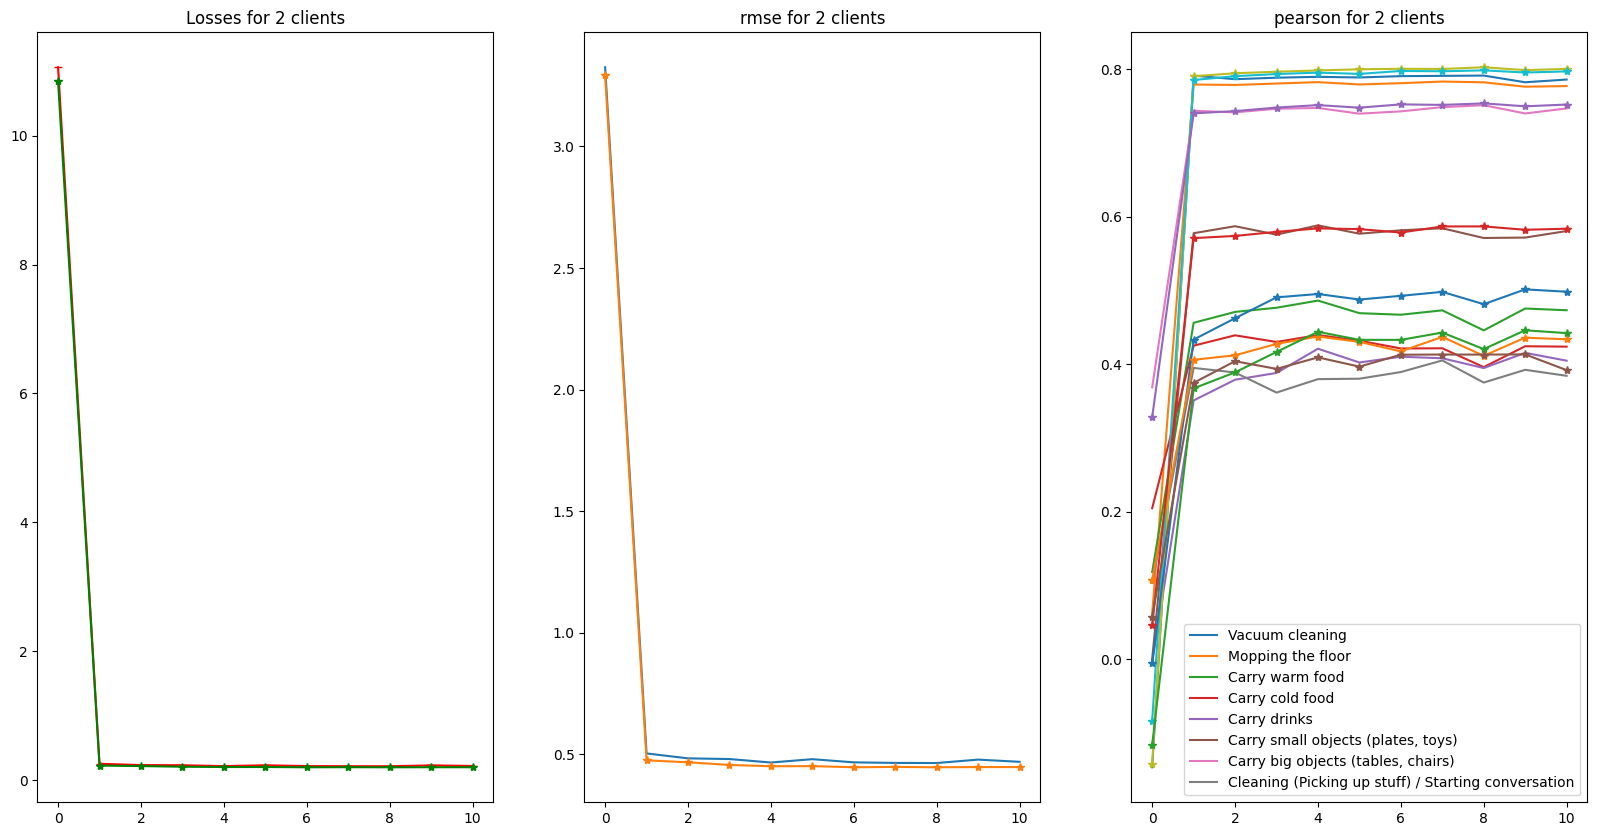

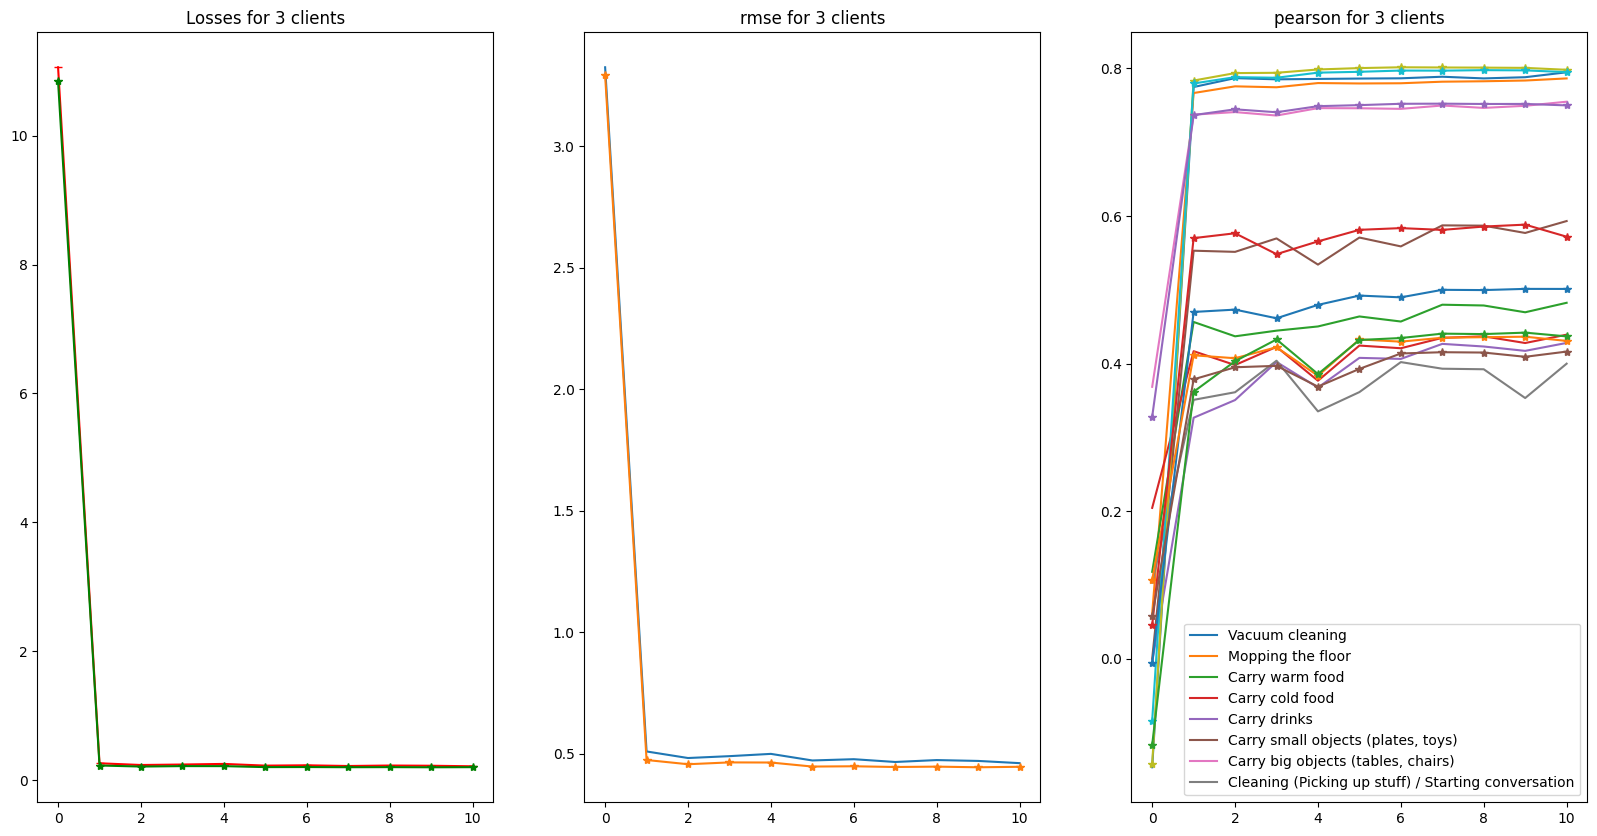

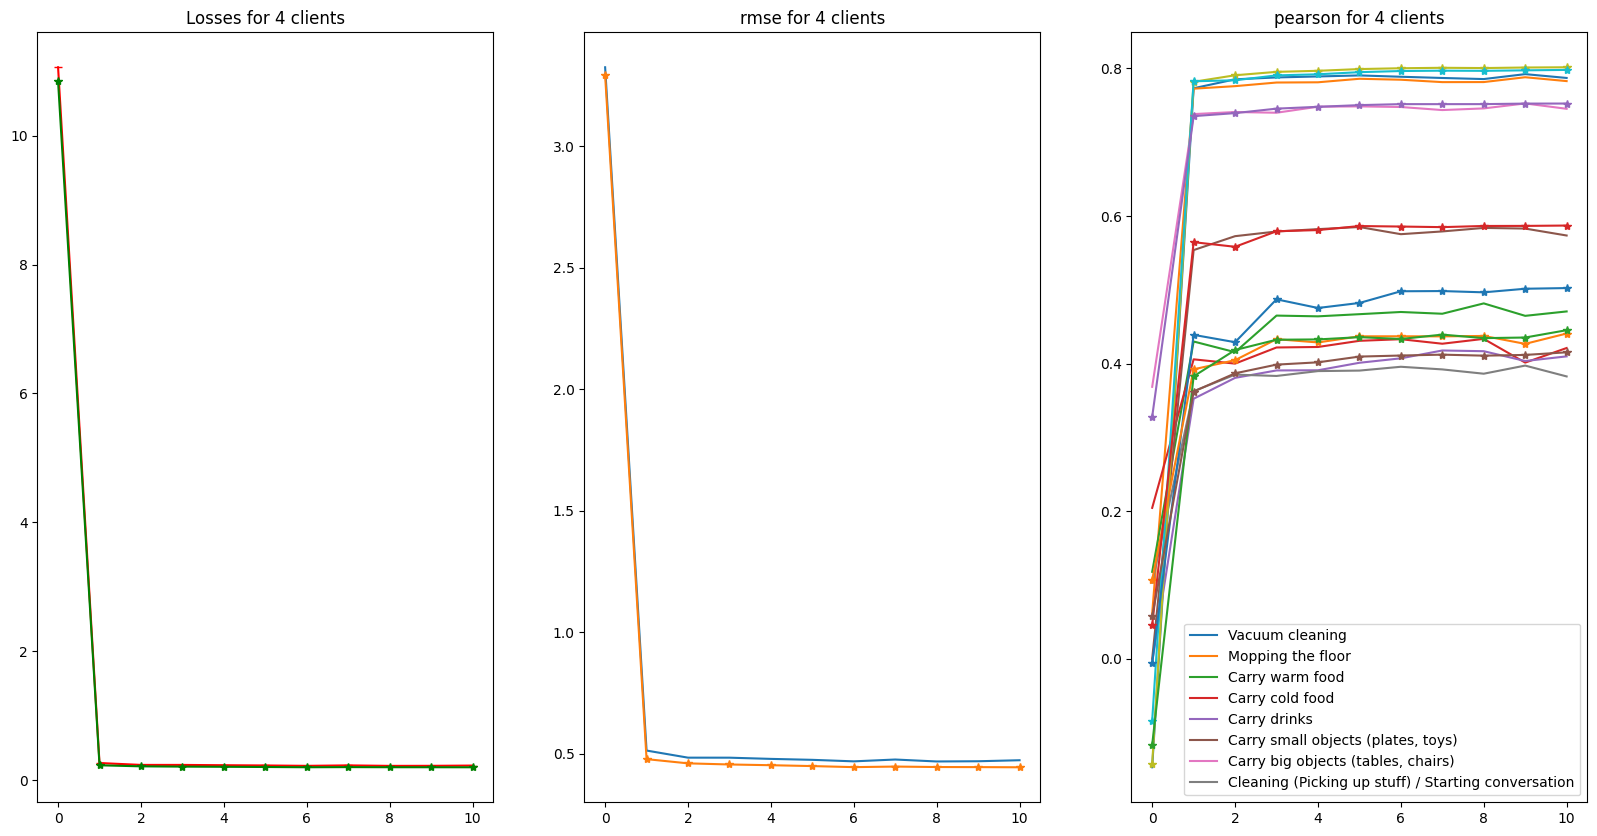

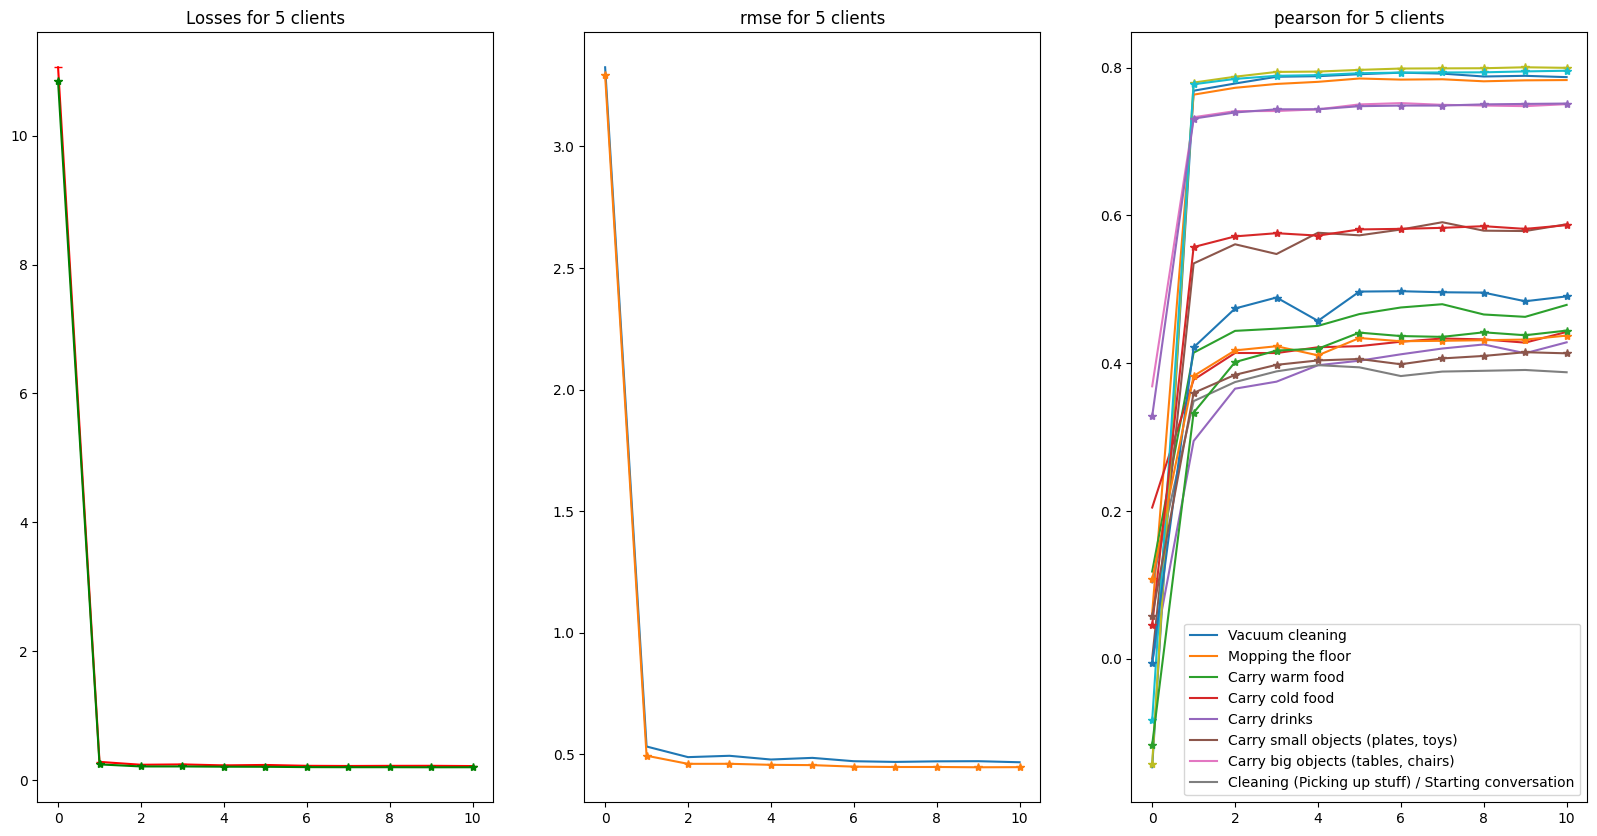

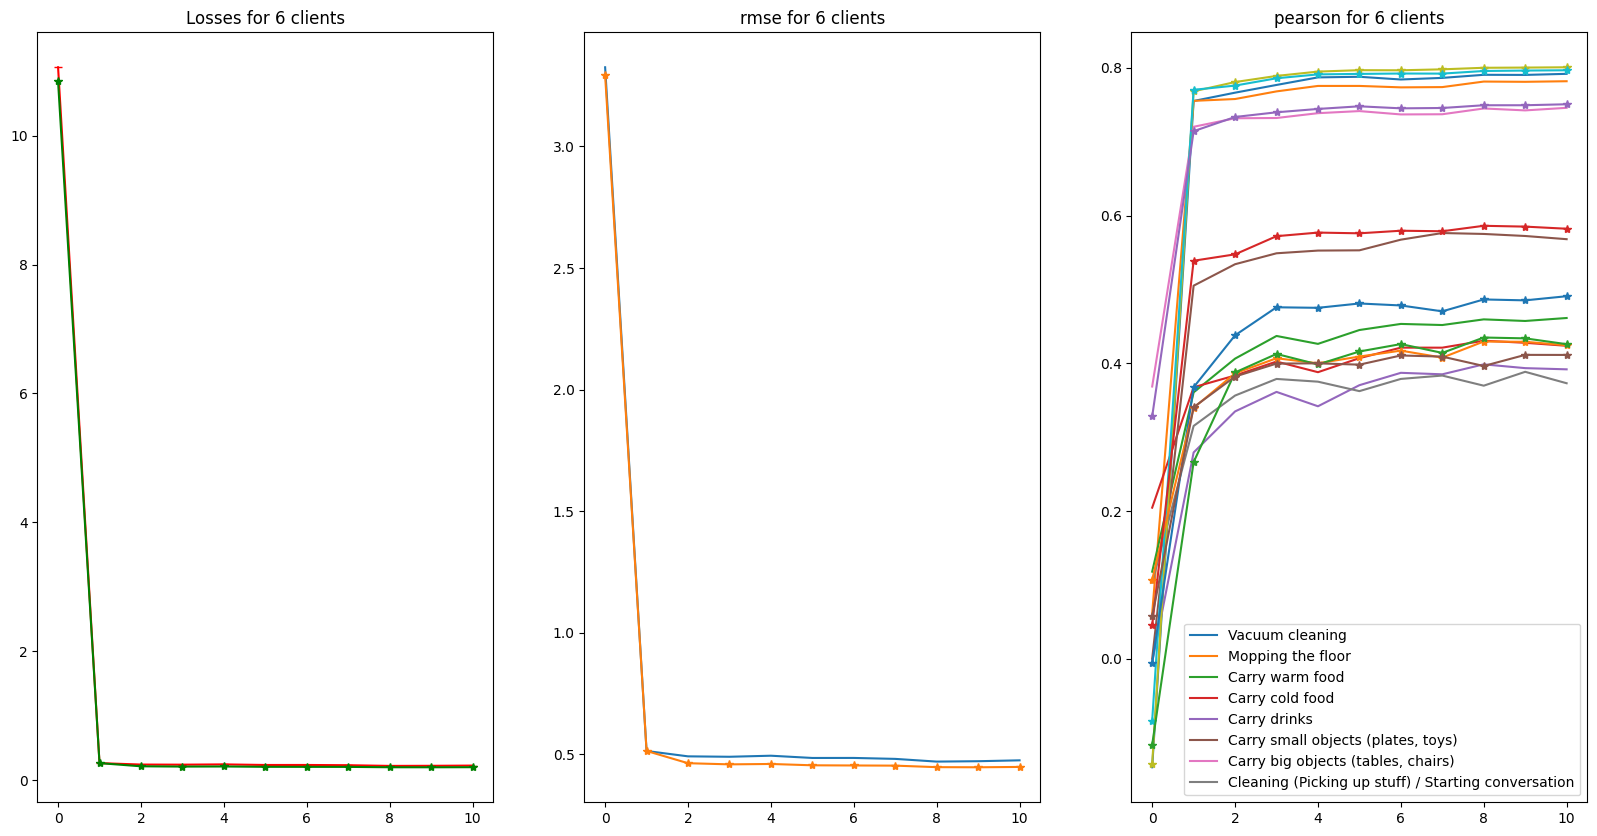

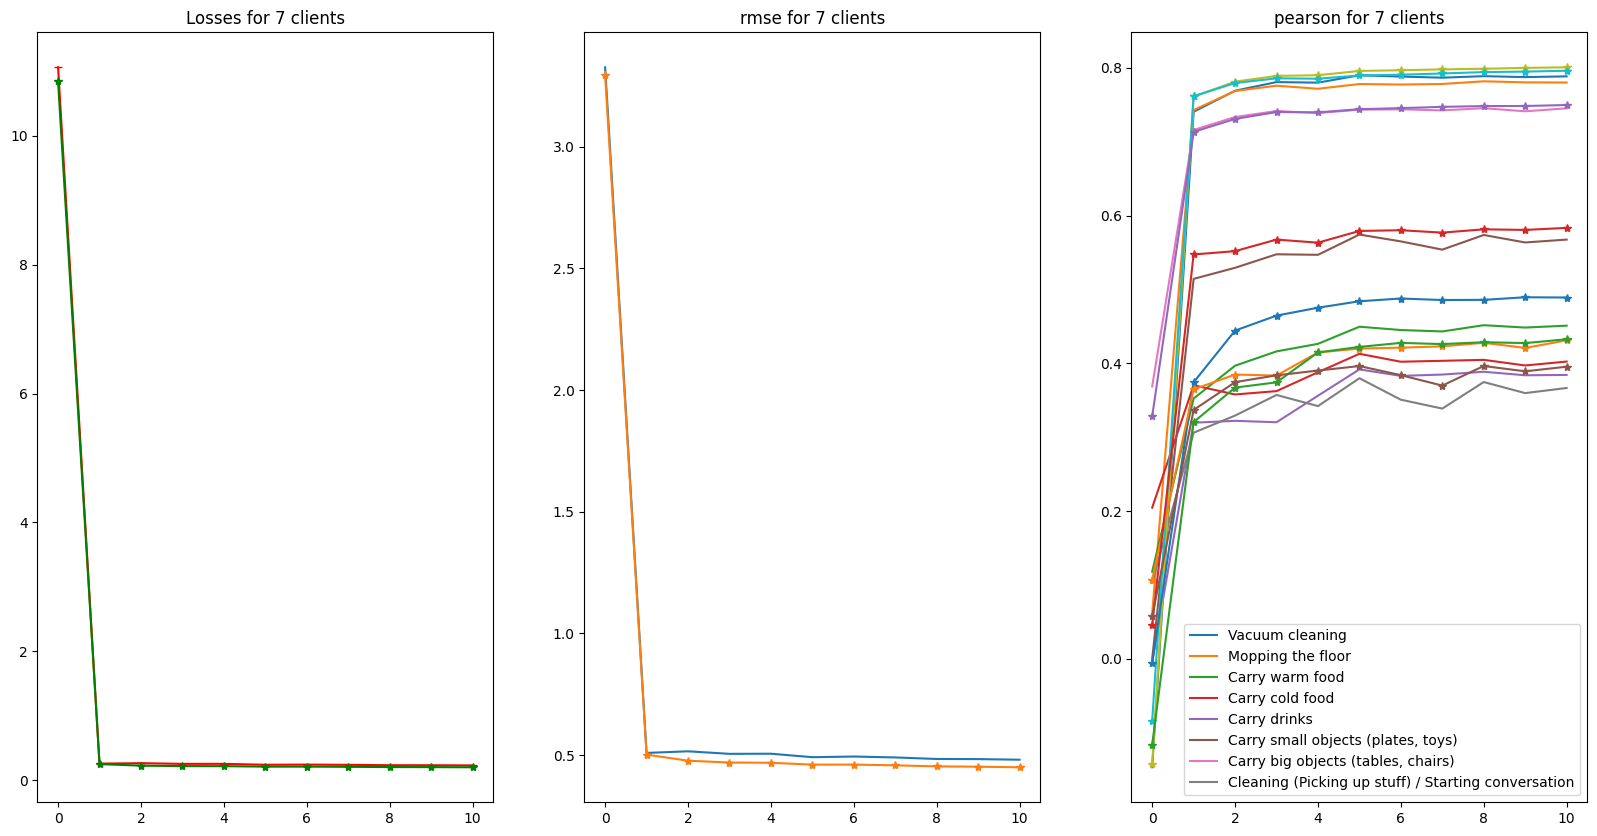

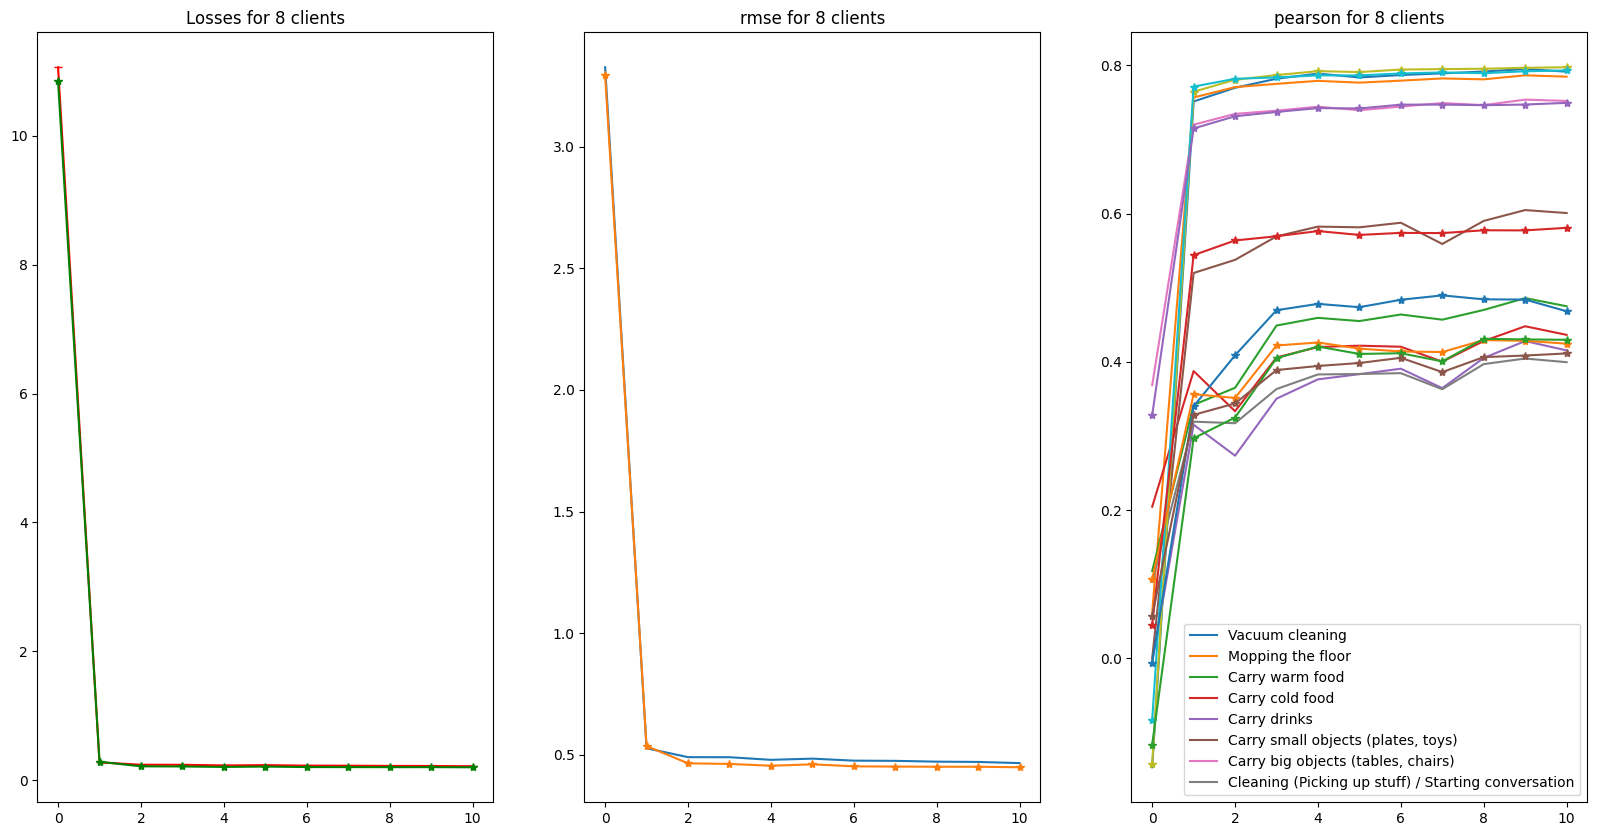

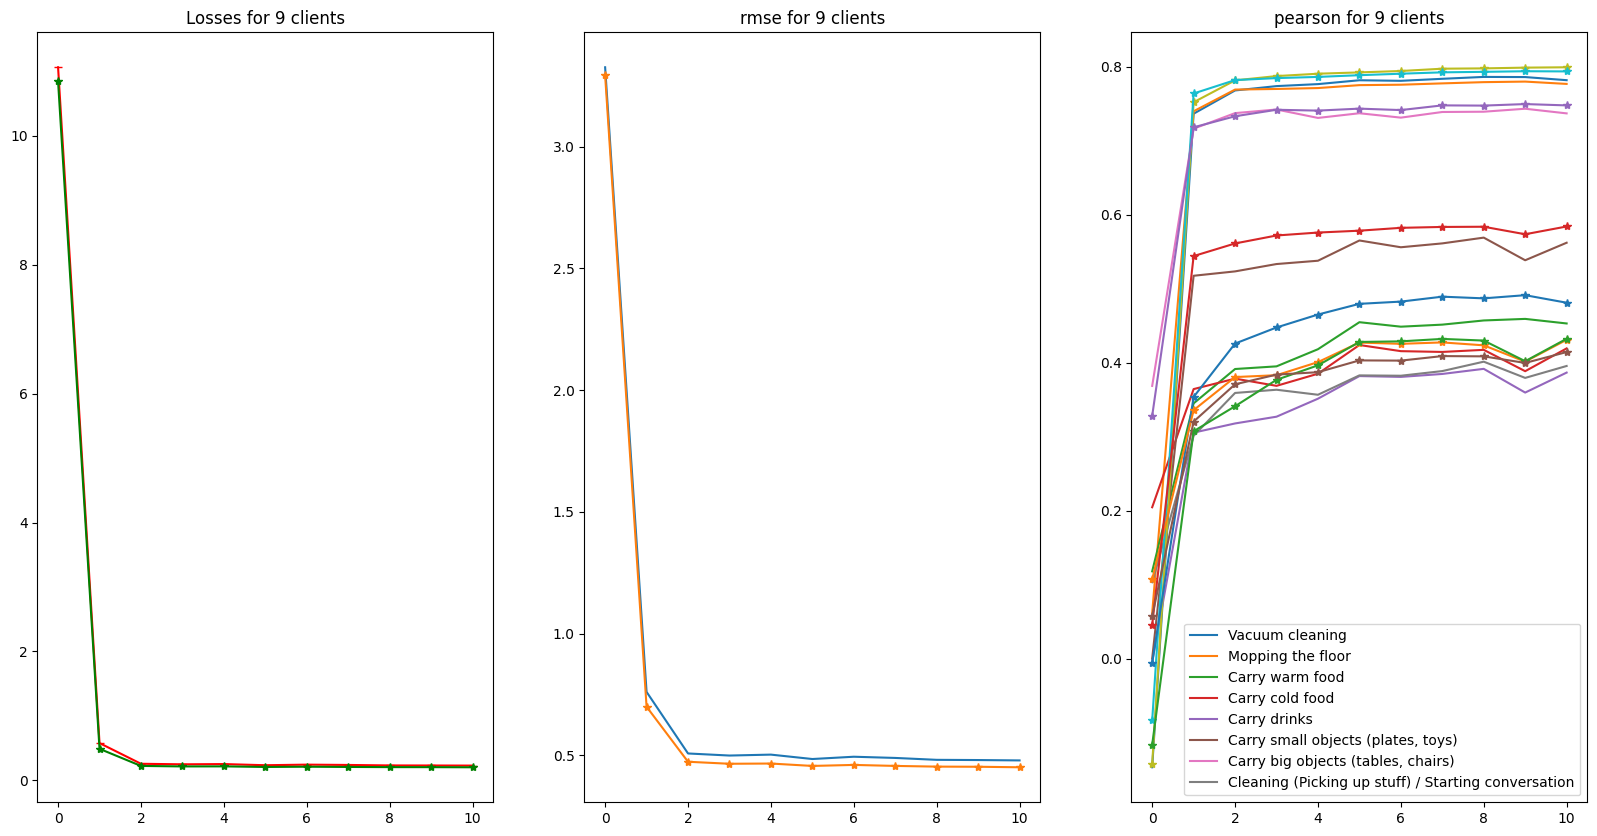

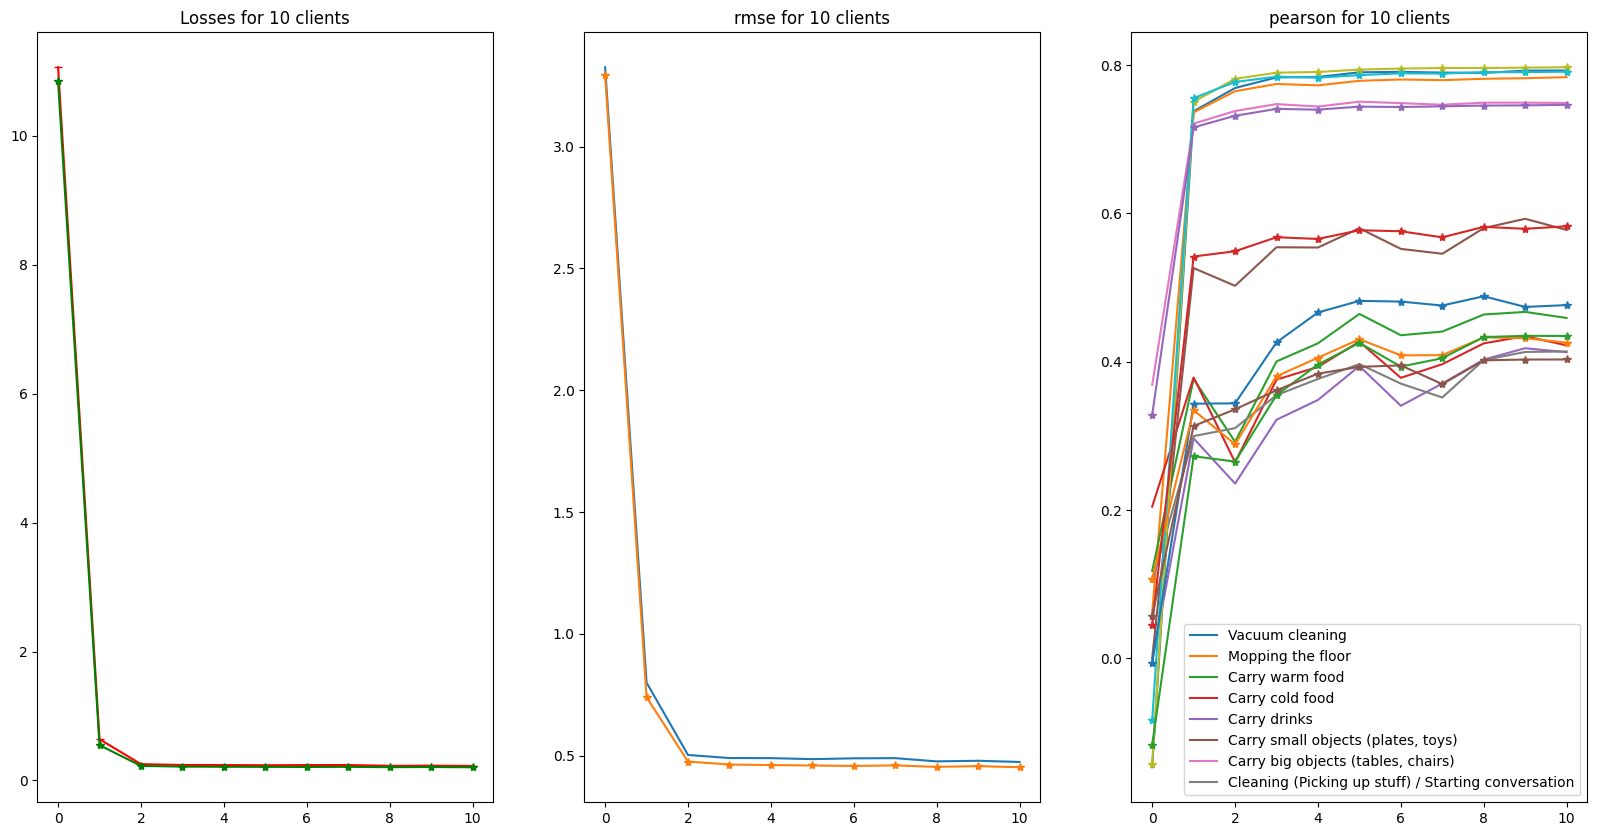

In [23]:
#for each client, plot losses, rmse in separate graphs and pearson of each label in a single graph with all labels marked in the legend
import matplotlib.pyplot as plt
for i in range(len(results)):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.plot(results[i]['Losses'], marker='_', color='red')
    plt.title("Losses for "+str(results[i]['clients'])+" clients")
    # plt.figure(figsize=(10,5))
    plt.plot(results_train[i]['Losses'],marker='*', color='green')
    plt.subplot(1,3,2)
    plt.plot(results[i]['rmse'])
    plt.plot(results_train[i]['rmse'], marker='*')

    plt.title("rmse for "+str(results[i]['clients'])+" clients")
    plt.subplot(1,3,3)
    for j in range(len(y_labels)):
        plt.plot(results[i]['pearson'][y_labels[j]])
    for j in range(len(y_labels)):
        plt.plot(results_train[i]['pearson'][y_labels[j]],marker='*')
    plt.title("pearson for "+str(results[i]['clients'])+" clients")
    plt.legend(y_labels)
    plt.savefig(f"{path}/{i+2}/{strat}.png")


In [24]:
import json
for i in range(len(results)):
    with open(f"{path}/{i+2}/{strat}/"+str(results[i]['clients'])+"clients.json", "w") as outfile:
        json.dump(results[i], outfile)


In [25]:
#load the results from the path "/results/fedAvgN" and create a dataframe with losses, rmse and average pearson of every label for each client
import json
import os
results=[]
for i in range(2,11):
    with open(f"{path}/{i}/{strat}/"+str(i)+"clients.json") as json_file:
        results.append(json.load(json_file))
import pandas as pd
df=pd.DataFrame(results)
df.head()

,clients,Losses,rmse,pearson
0,2,"[11.060606956481934, 0.2539086937904358, 0.233...","[3.325749158859253, 0.5038935542106628, 0.4836...","{'Vacuum cleaning': [-0.1468226751843182, 0.79..."
1,3,"[11.060606956481934, 0.2598985731601715, 0.233...","[3.325749158859253, 0.5098024606704712, 0.4827...","{'Vacuum cleaning': [-0.1468226751843182, 0.77..."
2,4,"[11.060606956481934, 0.2639978229999542, 0.234...","[3.325749158859253, 0.5138072371482849, 0.4845...","{'Vacuum cleaning': [-0.1468226751843182, 0.77..."
3,5,"[11.060606956481934, 0.2835961878299713, 0.238...","[3.325749158859253, 0.5325375199317932, 0.4888...","{'Vacuum cleaning': [-0.1468226751843182, 0.76..."
4,6,"[11.060606956481934, 0.264272004365921, 0.2420...","[3.325749158859253, 0.51407390832901, 0.492004...","{'Vacuum cleaning': [-0.1468226751843182, 0.75..."


In [26]:
df=pd.DataFrame(results)


In [27]:
#add a new column named pearson_avg
df['pearson_avg']=[[] for i in range(len(df))]


In [28]:
df.head()

,clients,Losses,rmse,pearson,pearson_avg
0,2,"[11.060606956481934, 0.2539086937904358, 0.233...","[3.325749158859253, 0.5038935542106628, 0.4836...","{'Vacuum cleaning': [-0.1468226751843182, 0.79...",[]
1,3,"[11.060606956481934, 0.2598985731601715, 0.233...","[3.325749158859253, 0.5098024606704712, 0.4827...","{'Vacuum cleaning': [-0.1468226751843182, 0.77...",[]
2,4,"[11.060606956481934, 0.2639978229999542, 0.234...","[3.325749158859253, 0.5138072371482849, 0.4845...","{'Vacuum cleaning': [-0.1468226751843182, 0.77...",[]
3,5,"[11.060606956481934, 0.2835961878299713, 0.238...","[3.325749158859253, 0.5325375199317932, 0.4888...","{'Vacuum cleaning': [-0.1468226751843182, 0.76...",[]
4,6,"[11.060606956481934, 0.264272004365921, 0.2420...","[3.325749158859253, 0.51407390832901, 0.492004...","{'Vacuum cleaning': [-0.1468226751843182, 0.75...",[]


In [29]:
y_labels=list(df['pearson'][0].keys())

for i in range(df.shape[0]):
    li=[]
    for k in range(10):
        sum=0
        for j in range(len(y_labels)):
            sum=sum+df['pearson'][i][y_labels[j]][k]
        sum=sum/10
        li.append(sum)
    df['pearson_avg'][i]=li



/tmp/ipykernel_213051/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_213051/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_213051/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_213051/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [30]:
for i in range(df.shape[0]):
  # mini=min(df['Losses'][i])
  # idx=df['Losses'][i].index(mini)
  # print(idx)
  idx=-1
  df['Losses'][i]=df['Losses'][i][idx]
  df['rmse'][i]=df['rmse'][i][idx]
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]


/tmp/ipykernel_213051/3851578825.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Losses'][i]=df['Losses'][i][idx]
/tmp/ipykernel_213051/3851578825.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rmse'][i]=df['rmse'][i][idx]
/tmp/ipykernel_213051/3851578825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]
/tmp/ipykernel_213051/3851578825.py:6: SettingWithCopyWarning: 
A v

In [31]:
df

,clients,Losses,rmse,pearson,pearson_avg
0,2,0.220361,0.469426,"{'Vacuum cleaning': [-0.1468226751843182, 0.79...",0.457816
1,3,0.213187,0.461721,"{'Vacuum cleaning': [-0.1468226751843182, 0.77...",0.456691
2,4,0.224658,0.473981,"{'Vacuum cleaning': [-0.1468226751843182, 0.77...",0.458351
3,5,0.21884,0.467803,"{'Vacuum cleaning': [-0.1468226751843182, 0.76...",0.45925
4,6,0.226207,0.475612,"{'Vacuum cleaning': [-0.1468226751843182, 0.75...",0.455378
5,7,0.231941,0.481603,"{'Vacuum cleaning': [-0.1468226751843182, 0.74...",0.446172
6,8,0.217386,0.466246,"{'Vacuum cleaning': [-0.1468226751843182, 0.75...",0.470723
7,9,0.229841,0.479418,"{'Vacuum cleaning': [-0.1468226751843182, 0.73...",0.443492
8,10,0.224892,0.474228,"{'Vacuum cleaning': [-0.1468226751843182, 0.73...",0.464955


In [32]:
df.drop(['pearson'], axis=1, inplace=True)

In [33]:
for i in range(df.shape[0]):
  try:
    data=pd.read_csv(f"{path}/clients{i+2}.csv")
    data.drop(["Unnamed: 0"], axis=1, inplace=True)
  except:
    data=pd.DataFrame(columns=["methods", "Loss", "RMSE", "PCC"])
  # data=data.append(pd.Series(["FedAvg_NoAug",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]]), ignore_index=True)
  data=pd.concat([data,pd.Series([f"{strat}",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]] , index=data.columns ).to_frame().T])
  data.to_csv(f"{path}/clients{i+2}.csv")

